<div class="alert alert-danger">

# PSL Intensive Week: AI for Economics and Finance
## Sylvain BENOIT -- Maître de Conférences en Economie (LEDa-SDFi)
### Université Paris Dauphine - PSL
    
### Part 2: Presentation of the results of the data processing pipeline for Tax Shortfall modeling on hidden work.

### 1/12/2023

</div>

<table align="left">
  <td>
    <a target="_blank" href="https://drive.google.com/file/d/11YZEz5QA-GD_6R_I4IYfAYAdYX9aG4tR/view?usp=drive_link"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

<div class="alert alert-warning">
    
## Introduction

Banulescu-Radu, D.,Benoit, S., Hurlin, C., [Shortfall in Tax Revenue: Evaluating the Social Security Contribution Fraud](https://www.dropbox.com/scl/fi/hvpakdj3oyiwx31lge5jj/BanulescuBenoitHurlin_ShortfallinTaxRevenue_WP_2023.pdf?rlkey=dy40tiynx8qnpcpj31utnujcw&dl=0), Working Paper, 2023.
    
[Link to the presentation.](https://www.dropbox.com/scl/fi/827t12h38rbjmfi6vjz1g/Slides_IntensiveWeek_BENOIT_STaX_HW.pdf?rlkey=9z1o2j23abgrcrb2ye6q2b1e1&dl=0)

[Link to Fake Databases.](https://www.dropbox.com/scl/fo/zf38z8q2gd3uco2012x1b/h?rlkey=59sl385sz2v6ok0curcnq0izi&dl=0)

</div>

# Table of contents <a id='section_0'></a>
* [Packages](#section_1)
* [Dataset on unreported work](#section_2)
* [Step 1 : Creation and analysis of target variables](#section_3)
* [Step 2 : Creation of variables and preliminary analysis](#section_4)
    * [Variables creation](#section_4.1)
    * [Analysis of controls and fraud rates by sectors](#section_4.2)
* [Step 3: Selection of explanatory variables for the probability of fraud](#section_6)
    * [X Quanti - Y Quali (Kruskall - Wallis Test)](#section_6.1)
    * [X Quali - Y Quali (Cramer's V Test)](#section_6.2)
    * [Variables selection](#section_6.3)
* [Step 4: Selection of explanatory variables for the adjustment amount](#section_7)
    * [X Quanti - Y Quanti (Correlation Test)](#section_7.1)
    * [X Quali - Y Quanti (Kruskall - Wallis Test)](#section_7.2)
    * [X Quali - Y Quali (Khi-2 Test)](#section_7.3)
    * [Variables selection](#section_7.4)
* [Step 5: Analysis of multicollinearity](#section_8)
    * [Cross-correlation analysis](#section_8.1)
    * [Selection of our numerical variables by dendogram and link to the target](#section_8.2)
* [Step 6: Discretisation and final selection](#section_9)
    * [Discretisation by quantiles](#section_9.1)
    * [Selection by analysis of target dependence (Cramer's V)](#section_9.2)
* [Step 7: Building the final base](#section_10)

# Packages <a id='section_1'></a>

In [1]:
# Importation packages
import pandas as pd
import numpy as np
import imblearn #unbalanced data

from datetime import datetime, timedelta

from sklearn import preprocessing # Label encoding
from scipy.stats import chi2_contingency, pearsonr, spearmanr, kendalltau, kruskal # Test Chi deux, Person, Spearman, Kendall kruskal-wallis
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from collections import defaultdict

from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF

from itertools import combinations

# Data vizz
import matplotlib.pyplot as plt
import seaborn as sns

# Exportation to Excel 
import openpyxl

# Dataset on unreported work <a id='section_2'></a>

*[Back to Table of contents](#section_0)*

In [2]:
# Path to the folder where you store the databases
path = 'C:/Users/sbenoit/Dropbox/Dauphine-SDFi/MyNotebook_Jupyter/Python_MAG/Data_IntensiveWeek/'

Variables names

In [3]:
Labels_X_SISAL = pd.read_excel(path + 'Fake_Documentation_base_estimation_td_avril2023.xlsx', sheet_name='Label_variables', skiprows=1)
Labels_X_SISAL = Labels_X_SISAL[['Variable','Label']].T
Labels_X_SISAL = Labels_X_SISAL.set_axis(Labels_X_SISAL.iloc[0], axis=1)
Labels_X_SISAL = Labels_X_SISAL.drop(Labels_X_SISAL.index[0])
Labels_X_SISAL = Labels_X_SISAL.set_index([pd.Index([0])])
Labels_X_SISAL

Variable,tot_mtt_redrest_tot,ccdrpdta,ancentr,lucea,mensu,nbtesa,pcdi,age_moy,age_ec,anc_moy,...,nbviecdi,nbviecdd,coti_etat,coti_emp,emb_mrmcdi,emb_heucdi,embcdd,emb_mrmcdd,emb_heucdd,ctrl_2014
0,Montant de redressement total,Catégorie de risque prépondérant AT de l'entre...,Ancienneté de l'entreprise,LUCEA O/N,MENSU,Nombre de Tesa,% salariés en CDI,Age moyen du salarié,Ecart-type de l'âge du salarié,Ancienneté moyenne du salarié au sein de l'ent...,...,Nombre de CDI encore en vie au 31/12/AAAA,Nombre de CDD encore en vie au 31/12/AAAA,Montant cotisations prises en charge par l'Etat,Montant cotisations payées par l'employeur,Montant rémunération embauchés en cdi,Nb heures embauchés en cdi,Nb embauchés en cdd,Montant rémunération embauchés en cdd,Nb heures embauchés en cdd,"=1 si l'entreprise est contrôlée, 0 sinon"


Dataset on unreported work entitled Fake_ASSIETTE_TID_SISAL_2014 with only paired instances.

In [4]:
Data_SISAL = pd.read_excel(path + 'Fake_ASSIETTE_TID_SISAL_2014.xlsx')

In [5]:
Data_SISAL.shape

(162390, 45)

In [6]:
# Number of controls observed in the dataset
print(Data_SISAL['ctrl_2014'].sum())

2390


In [7]:
Columns_Name_SISAL = Data_SISAL.columns
Columns_Name_SISAL

Index(['ccdrpdta', 'ancentr', 'lucea', 'mensu', 'nbtesa', 'pcdi', 'age_moy',
       'age_ec', 'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec',
       'nombre_mensuel_moyen_sal', 'nombre_mensuel_moyen_CDI', 'etpetabl',
       'nbetab', 'nbcdi', 'nbcdd', 'nbsaison', 'heucdi', 'mrmcdi', 'joucdi',
       'heucdd', 'mrmcdd', 'joucdd', 'nbheures', 'heu_tec', 'heu_bur', 'nbsal',
       'sal_hom', 'sal_fem', 'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat',
       'coti_emp', 'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd',
       'emb_heucdd', 'ctrl_2014', 'tot_mtt_redrest_tot', 'clé_merge',
       'classif_algo'],
      dtype='object')

In [8]:
# We need to know the type of this variables
type(Columns_Name_SISAL) 

pandas.core.indexes.base.Index

In [9]:
# Keep only names of covariates
Columns_SISAL = Columns_Name_SISAL[0:-4]
Columns_SISAL

Index(['ccdrpdta', 'ancentr', 'lucea', 'mensu', 'nbtesa', 'pcdi', 'age_moy',
       'age_ec', 'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec',
       'nombre_mensuel_moyen_sal', 'nombre_mensuel_moyen_CDI', 'etpetabl',
       'nbetab', 'nbcdi', 'nbcdd', 'nbsaison', 'heucdi', 'mrmcdi', 'joucdi',
       'heucdd', 'mrmcdd', 'joucdd', 'nbheures', 'heu_tec', 'heu_bur', 'nbsal',
       'sal_hom', 'sal_fem', 'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat',
       'coti_emp', 'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd',
       'emb_heucdd'],
      dtype='object')

In [10]:
print(len(Columns_SISAL))
print("Names of explanatory variables")
Labels_X_SISAL[Columns_SISAL].T

41
Names of explanatory variables


,0
Variable,
ccdrpdta,Catégorie de risque prépondérant AT de l'entre...
ancentr,Ancienneté de l'entreprise
lucea,LUCEA O/N
mensu,MENSU
nbtesa,Nombre de Tesa
pcdi,% salariés en CDI
age_moy,Age moyen du salarié
age_ec,Ecart-type de l'âge du salarié
anc_moy,Ancienneté moyenne du salarié au sein de l'ent...


In [11]:
# display this DataFrame
Data_SISAL[Columns_SISAL].head()

,ccdrpdta,ancentr,lucea,mensu,nbtesa,pcdi,age_moy,age_ec,anc_moy,anc_ec,...,masse_tot,nbviecdi,nbviecdd,coti_etat,coti_emp,emb_mrmcdi,emb_heucdi,embcdd,emb_mrmcdd,emb_heucdd
0,190,15,0,0,1,0.000000,58.000000,0.000000,0.00000,0.000000,...,0.082500,0,0,0.023306,0.009197,0.0,0,1,0.082500,24
1,190,15,0,0,5,0.000000,37.400000,20.519259,0.20000,0.400000,...,1.508438,0,4,0.426141,0.168197,0.0,0,4,0.865625,260
2,190,15,0,0,0,0.000000,39.000000,0.000000,2.00000,0.000000,...,1.094375,0,0,0.345288,0.134066,0.0,0,0,0.000000,0
3,190,15,0,0,3,0.000000,21.666667,12.256518,0.00000,0.000000,...,0.672188,0,2,0.174044,0.090819,0.0,0,3,0.672188,218
4,190,14,0,0,20,0.037037,45.148148,11.699015,0.37037,1.023724,...,19.090000,1,3,5.830616,2.155694,0.0,0,22,9.454375,2885


In [12]:
ctrl_2014 = Data_SISAL['ctrl_2014']
classif = Data_SISAL['classif_algo']

In [13]:
# Number of controls observed in SISAL
print(Data_SISAL['ctrl_2014'].sum())

2390


In [14]:
print(Data_SISAL.shape)

(162390, 45)


# Step 1 : Creation and analysis of target variables <a id='section_3'></a>

*[Back to Table of contents](#section_0)*

Analysis of `mtt_tot_redrest_tot`.

In [15]:
# Please define the target variable
target = "tot_mtt_redrest_tot"

In [16]:
print(f"The amount of fraud due to unreported work is equal to {Data_SISAL[target].sum()}.")
print(Data_SISAL[target].describe().apply("{0:.6f}".format))

The amount of fraud due to unreported work is equal to 14337.52278125.
count    2390.000000
mean        5.998964
std        44.696493
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1509.345812
Name: tot_mtt_redrest_tot, dtype: object


In [17]:
print("How many NaNs in the target variable ?")
print(Data_SISAL[target].isna().sum())
print("Descriptive statistics on the target (!=NaN):")
print(Data_SISAL[target].describe().apply("{0:.6f}".format))
print("Descriptive statistics on the target (=0):")
print(Data_SISAL[(Data_SISAL[target] == 0)][target].describe().apply("{0:.6f}".format))
print("Descriptive statistics on the target (>0):")
print(Data_SISAL[(Data_SISAL[target] > 0)][target].describe().apply("{0:.6f}".format))
print("Sum on the target (>0), check:")
print(Data_SISAL[(Data_SISAL[target] > 0)][target].sum())

How many NaNs in the target variable ?
160000
Descriptive statistics on the target (!=NaN):
count    2390.000000
mean        5.998964
std        44.696493
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1509.345812
Name: tot_mtt_redrest_tot, dtype: object
Descriptive statistics on the target (=0):
count    1894.000000
mean        0.000000
std         0.000000
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.000000
Name: tot_mtt_redrest_tot, dtype: object
Descriptive statistics on the target (>0):
count     496.000000
mean       28.906296
std        94.753840
min         0.001812
25%         1.745406
50%         9.150359
75%        26.017641
max      1509.345812
Name: tot_mtt_redrest_tot, dtype: object
Sum on the target (>0), check:
14337.522781250002


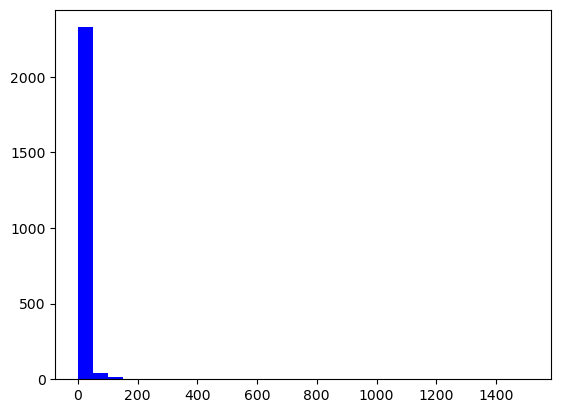

In [18]:
plt.hist(Data_SISAL[target], label ="Montant du Redressement", color ="b", bins = 30)
plt.show()

Ponctual mass in 0, it's probably impossible to model the target variable for all the companies we monitor, so a two-stage approach is required. 

We would therefore need to model in two stages:

    1. Model the probability of fraud or nonfraud, then
    2. Model the amounts of tax adjustments

Creation of two new target variables: `Fraude` et `Montants`.

In [19]:
Data_SISAL['Fraude'] = np.where(Data_SISAL[target] > 0, 1, Data_SISAL[target])
Data_SISAL['Fraude_num'] = Data_SISAL['Fraude']
Data_SISAL['Montants'] = np.where(Data_SISAL[target] > 0, Data_SISAL[target], np.nan)

In [20]:
print(f"The number of fraud due to unreported work is equal to {Data_SISAL['Fraude'].sum()}.")

The number of fraud due to unreported work is equal to 496.0.


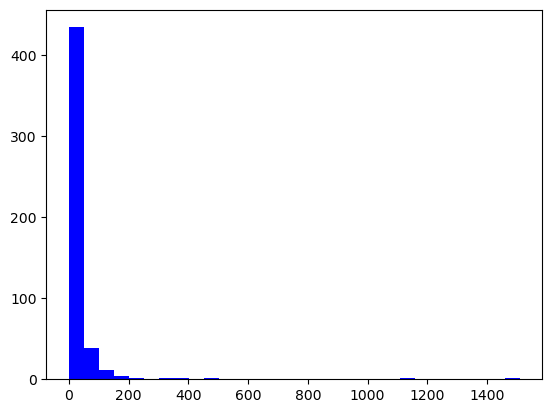

In [21]:
Data_SISAL_Histo = Data_SISAL[Data_SISAL[target] > 0] 
plt.hist(Data_SISAL_Histo[target], label ="Amount of tax adjustment", color ="b", bins = 30)
plt.show()

We do have outliers but we keep them.

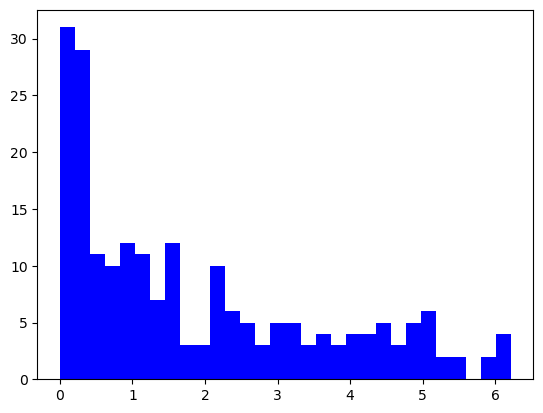

In [22]:
Data_SISAL_Histo = Data_SISAL[(Data_SISAL[target] > 0) & (Data_SISAL[target] < 6.25)]
plt.hist(Data_SISAL_Histo[target], label ="Montant du Redressement", color ="b", bins = 30)
plt.show()

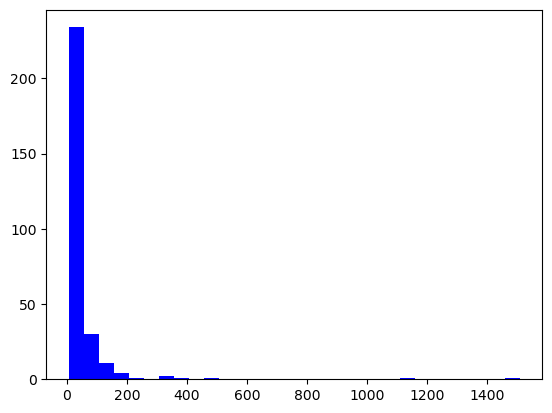

In [23]:
Data_SISAL_Histo = Data_SISAL[(Data_SISAL[target] > 0) & (Data_SISAL[target] > 6.25)]
plt.hist(Data_SISAL_Histo[target], label ="Montant du Redressement", color ="b", bins = 30)
plt.show()

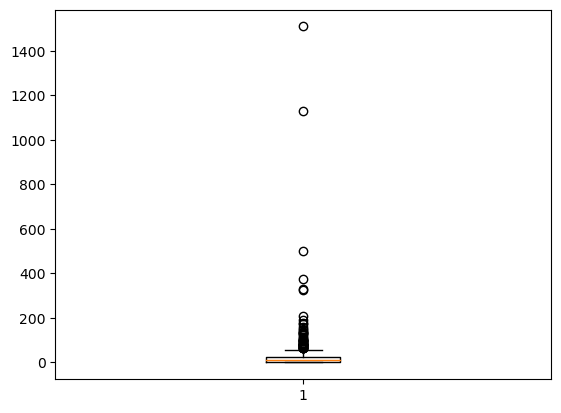

In [24]:
plt.boxplot(Data_SISAL[Data_SISAL[target] > 0][target])
plt.show()

# Step 2 : Creation of variables and preliminary analysis <a id='section_4'></a>

*[Back to Table of contents](#section_0)*

## Variables creation <a id='section_4.1'></a>

Creation of `coti_tot`

In [25]:
# Montant des cotisations totales
Data_SISAL['coti_tot'] = Data_SISAL['coti_etat'] + Data_SISAL['coti_emp']

In [26]:
Columns_SISAL = Columns_SISAL.append(pd.Index(['coti_tot']))

In [27]:
# I add this variable of my labels of X
Labels_X_SISAL['coti_tot'] = 'Cotisation Totale'

Definition of functions for transforming the ccdrpdta variable (39 modalities) - the company's predominant AT risk category - into 3 new variables containing 7, 13 and 15 classes respectively.

In [28]:
# create a function to map ccdrpdta to ccdrpdta15cl
def map_ccdrpdta15cl(ccdrpdta):
    ccdrpdta = str(int(ccdrpdta)) # convert to string the int part, sinon enlever les "110" autour des chiffres comme 110 dans mon exempleColumns_SISAL
    if ccdrpdta == "110":
        return "Cultures spécialisées" # "01"
    elif ccdrpdta == "120":
        return "Champignonnières" # "02"
    elif ccdrpdta == "130":
        return "Elevage spécialisés gros animaux" # "03"
    elif ccdrpdta == "140":
        return "Elevage spécialisés petits animaux" # "04"
    elif ccdrpdta == "150":
        return "Entrainement, dressage, haras" # "05"
    elif ccdrpdta == "160":
        return "Conchyliculture" # "06"
    elif ccdrpdta == "170":
        return "Marais salants" # "07"
    elif ccdrpdta == "180":
        return "Culture et élevage non spécialisés"# "08" 
    elif ccdrpdta == "190":
        return "Viticulture" # "09"
    elif ccdrpdta in ["310", "320", "330", "340"]:
        return "Travaux forestiers" # "10"
    elif ccdrpdta in ["400", "410"]:
        return "Entreprises de travaux agricoles" # "11" 
    elif ccdrpdta in ["500", "510"]:
        return "Entreprises d'artisanat rural" #  "12"
    elif ccdrpdta in ["600", "610", "620", "630", "640", "650", "660", "670", "680", "690", "760", "770"]:
        return "Entreprises de coopération" # "13"
    elif ccdrpdta in ["801", "811", "821", "830"]:
        return "Organismes de service" # "14"
    elif ccdrpdta in ["900", "910", "920", "940", "950", "970"]:
        return "Activités diverses" # "15"
    else:
        return None # return None if no match is found

# create a new column ccdrpdta15cl based on the function
Data_SISAL["ccdrpdta15cl"] = Data_SISAL["ccdrpdta"].apply(map_ccdrpdta15cl)

# create a function to map ccdrpdta15cl to ccdrpdta13cl
def map_ccdrpdta13cl(ccdrpdta15cl):
    if ccdrpdta15cl in ["Champignonnières", "Conchyliculture", "Marais salants"]: # ["02", "06", "07"]
        return "Champi - Conchy - Marais sal" # "02"
    else:
        return ccdrpdta15cl

# create a new column ccdrpdta13cl based on the function
Data_SISAL["ccdrpdta13cl"] = Data_SISAL["ccdrpdta15cl"].apply(map_ccdrpdta13cl)

def map_ccdrpdta7cl(ccdrpdta):
    ccdrpdta = str(int(ccdrpdta)) # convert to string
    if ccdrpdta[0] == "1":
        return "Total exploitations" # "09"
    elif ccdrpdta[0] == "3":
        return "Total travaux forestiers" # "10"
    elif ccdrpdta[0] == "4":
        return "Total travaux agricoles" # "11"
    elif ccdrpdta[0] == "5":
        return "Total artisanat rural" # "12"
    elif ccdrpdta[0] in ["6", "7"]:
        return "Total entreprises de coopération" # "13"
    elif ccdrpdta[0] == "8":
        return "Total organismes de service" # "14"
    elif ccdrpdta[0] == "9":
        return "Total activités diverses" # "15"

# create a new column ccdrpdta7cl based on the function
Data_SISAL["ccdrpdta7cl"] = Data_SISAL["ccdrpdta"].apply(map_ccdrpdta7cl)

## Analysis of controls and fraud rates by sectors  <a id='section_4.2'></a>

In [29]:
# Creates variables are string
ccdrpdta15cl_counts = Data_SISAL['ccdrpdta15cl'].value_counts().sort_index()
ccdrpdta15cl_sum = Data_SISAL[Data_SISAL[target].notna()].groupby('ccdrpdta15cl')[['ctrl_2014','Fraude','Montants']].sum().sort_index()
ccdrpdta15cl_output = pd.merge(ccdrpdta15cl_counts, ccdrpdta15cl_sum, left_index=True, right_index=True)
# Control rate
ccdrpdta15cl_output['Control_rate'] = (ccdrpdta15cl_output['ctrl_2014']/ccdrpdta15cl_output['ccdrpdta15cl'])*100
# Fraud rate (out of number of controls)
ccdrpdta15cl_output['Fraude_rate'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['ctrl_2014'])
# Fraud rate (out of number of observations)
ccdrpdta15cl_output['Fraude_rate_all'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['ccdrpdta15cl'])
ccdrpdta15cl_output['Montants_moyen'] = ccdrpdta15cl_output['Montants']/ccdrpdta15cl_output['Fraude']
ccdrpdta15cl_output = ccdrpdta15cl_output.fillna(0)
ccdrpdta15cl_output
ccdrpdta15cl_output.style.format({"Fraude":"{:.0f}", "Montants":"{:.0f}", "Control_rate":"{:.2%}", "Fraude_rate":"{:.2%}", "Fraude_rate_all":"{:.2%}", "Montants_moyen":"{:.0f}"})

,ccdrpdta15cl,ctrl_2014,Fraude,Montants,Control_rate,Fraude_rate,Fraude_rate_all,Montants_moyen
Activités diverses,5126,16,9,457,31.21%,56.25%,0.18%,51
Champignonnières,57,1,0,0,175.44%,0.00%,0.00%,0
Conchyliculture,1619,95,11,38,586.78%,11.58%,0.68%,3
Culture et élevage non spécialisés,54581,299,82,1228,54.78%,27.42%,0.15%,15
Cultures spécialisées,19062,602,101,3183,315.81%,16.78%,0.53%,32
Elevage spécialisés gros animaux,7346,57,25,337,77.59%,43.86%,0.34%,13
Elevage spécialisés petits animaux,5061,50,12,118,98.79%,24.00%,0.24%,10
"Entrainement, dressage, haras",5630,166,33,606,294.85%,19.88%,0.59%,18
Entreprises d'artisanat rural,1009,3,0,0,29.73%,0.00%,0.00%,0
Entreprises de coopération,2667,30,0,0,112.49%,0.00%,0.00%,0


In [30]:
# Creates variables are string
ccdrpdta15cl_counts = Data_SISAL['classif_algo'].value_counts().sort_index()
ccdrpdta15cl_sum = Data_SISAL[Data_SISAL[target].notna()].groupby('classif_algo')[['ctrl_2014','Fraude','Montants']].sum().sort_index()
ccdrpdta15cl_output = pd.merge(ccdrpdta15cl_counts, ccdrpdta15cl_sum, left_index=True, right_index=True)
# Control rate
ccdrpdta15cl_output['Control_rate'] = (ccdrpdta15cl_output['ctrl_2014']/ccdrpdta15cl_output['classif_algo'])
# Fraud rate (out of number of controls)
ccdrpdta15cl_output['Fraude_rate'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['ctrl_2014'])
# Fraud rate (out of number of observations)
ccdrpdta15cl_output['Fraude_rate_all'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['classif_algo'])
ccdrpdta15cl_output['Montants_moyen'] = ccdrpdta15cl_output['Montants']/ccdrpdta15cl_output['Fraude']
ccdrpdta15cl_output = ccdrpdta15cl_output.fillna(0)
ccdrpdta15cl_output
ccdrpdta15cl_output.style.format({"Fraude":"{:.0f}", "Montants":"{:.0f}", "Control_rate":"{:.2%}", "Fraude_rate":"{:.2%}", "Fraude_rate_all":"{:.2%}", "Montants_moyen":"{:.0f}"})

,classif_algo,ctrl_2014,Fraude,Montants,Control_rate,Fraude_rate,Fraude_rate_all,Montants_moyen
Activités diverses,5126,16,9,457,0.31%,56.25%,0.18%,51
Conchyliculture,1787,97,12,77,5.43%,12.37%,0.67%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,597,0.48%,25.00%,0.12%,21
Culture et élevage non spécialisés 0150Z,8065,26,9,103,0.32%,34.62%,0.11%,11
Culture et élevage non spécialisés autres,9943,95,18,287,0.96%,18.95%,0.18%,16
Culture et élevage non spécialisés bovins,12466,62,26,242,0.50%,41.94%,0.21%,9
Cultures spécialisées 0111Z,3178,63,9,157,1.98%,14.29%,0.28%,17
Cultures spécialisées 0113Z,4737,153,40,1206,3.23%,26.14%,0.84%,30
Cultures spécialisées 0124Z,3745,195,23,906,5.21%,11.79%,0.61%,39
Cultures spécialisées 0130Z,2345,61,7,80,2.60%,11.48%,0.30%,11


In [31]:
Data_SISAL['classif_algo'] = Data_SISAL['classif_algo'].str.replace('Elevage spécialisés gros animaux 0146Z','Elevage spécialisés gros animaux')
Data_SISAL['classif_algo'] = Data_SISAL['classif_algo'].str.replace('Elevage spécialisés gros animaux autres','Elevage spécialisés gros animaux')
Data_SISAL['classif_algo'] = Data_SISAL['classif_algo'].str.replace('Activités diverses','Act. diverses et Org. service')
Data_SISAL['classif_algo'] = Data_SISAL['classif_algo'].str.replace('Organismes de service','Act. diverses et Org. service')
Data_SISAL['classif_algo'] = Data_SISAL['classif_algo'].str.replace('Culture et élevage non spécialisés 0150Z','Culture et élevage non spécialisés autres')

In [32]:
# Creates variables are string
ccdrpdta15cl_counts = Data_SISAL['classif_algo'].value_counts().sort_index()
ccdrpdta15cl_sum = Data_SISAL[Data_SISAL[target].notna()].groupby('classif_algo')[['ctrl_2014','Fraude','Montants']].sum().sort_index()
ccdrpdta15cl_output = pd.merge(ccdrpdta15cl_counts, ccdrpdta15cl_sum, left_index=True, right_index=True)
# Control rate
ccdrpdta15cl_output['Control_rate'] = (ccdrpdta15cl_output['ctrl_2014']/ccdrpdta15cl_output['classif_algo'])
# Fraud rate (out of number of controls)
ccdrpdta15cl_output['Fraude_rate'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['ctrl_2014'])
# Fraud rate (out of number of observations)
ccdrpdta15cl_output['Fraude_rate_all'] = (ccdrpdta15cl_output['Fraude']/ccdrpdta15cl_output['classif_algo'])
ccdrpdta15cl_output['Montants_moyen'] = ccdrpdta15cl_output['Montants']/ccdrpdta15cl_output['Fraude']
ccdrpdta15cl_output = ccdrpdta15cl_output.fillna(0)
ccdrpdta15cl_output
ccdrpdta15cl_output.style.format({"Fraude":"{:.0f}", "Montants":"{:.0f}", "Control_rate":"{:.2%}", "Fraude_rate":"{:.2%}", "Fraude_rate_all":"{:.2%}", "Montants_moyen":"{:.0f}"})

,classif_algo,ctrl_2014,Fraude,Montants,Control_rate,Fraude_rate,Fraude_rate_all,Montants_moyen
Act. diverses et Org. service,9762,32,13,503,0.33%,40.62%,0.13%,39
Conchyliculture,1787,97,12,77,5.43%,12.37%,0.67%,6
Culture et élevage non spécialisés 0111Z,24107,116,29,597,0.48%,25.00%,0.12%,21
Culture et élevage non spécialisés autres,18008,121,27,390,0.67%,22.31%,0.15%,14
Culture et élevage non spécialisés bovins,12466,62,26,242,0.50%,41.94%,0.21%,9
Cultures spécialisées 0111Z,3178,63,9,157,1.98%,14.29%,0.28%,17
Cultures spécialisées 0113Z,4737,153,40,1206,3.23%,26.14%,0.84%,30
Cultures spécialisées 0124Z,3745,195,23,906,5.21%,11.79%,0.61%,39
Cultures spécialisées 0130Z,2345,61,7,80,2.60%,11.48%,0.30%,11
Cultures spécialisées autres,7781,161,22,834,2.07%,13.66%,0.28%,38


In [33]:
Columns_SISAL = Columns_SISAL.append(pd.Index(['ccdrpdta7cl','ccdrpdta13cl','ccdrpdta15cl','classif_algo']))

In [34]:
Columns_SISAL = Columns_SISAL.drop(pd.Index(['ccdrpdta']))

In [35]:
# I add these variables in my labels of X
Labels_X_SISAL['ccdrpdta7cl'] = 'Cat. Risque prépondérant AT 7cl'
Labels_X_SISAL['ccdrpdta13cl'] = 'Cat. Risque prépondérant AT 13cl'
Labels_X_SISAL['ccdrpdta15cl'] = 'Cat. Risque prépondérant AT 15cl'
Labels_X_SISAL['classif_algo'] = 'Cat. Risque Algorithmique'

Potential explanatory variables

In [36]:
Columns_SISAL

Index(['ancentr', 'lucea', 'mensu', 'nbtesa', 'pcdi', 'age_moy', 'age_ec',
       'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec', 'nombre_mensuel_moyen_sal',
       'nombre_mensuel_moyen_CDI', 'etpetabl', 'nbetab', 'nbcdi', 'nbcdd',
       'nbsaison', 'heucdi', 'mrmcdi', 'joucdi', 'heucdd', 'mrmcdd', 'joucdd',
       'nbheures', 'heu_tec', 'heu_bur', 'nbsal', 'sal_hom', 'sal_fem',
       'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat', 'coti_emp',
       'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd', 'emb_heucdd',
       'coti_tot', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl',
       'classif_algo'],
      dtype='object')

In [37]:
len(Columns_SISAL)

45

In [38]:
# display DataFrame
Data_SISAL[Columns_SISAL].head()

,ancentr,lucea,mensu,nbtesa,pcdi,age_moy,age_ec,anc_moy,anc_ec,sal_moy,...,emb_mrmcdi,emb_heucdi,embcdd,emb_mrmcdd,emb_heucdd,coti_tot,ccdrpdta7cl,ccdrpdta13cl,ccdrpdta15cl,classif_algo
0,15,0,0,1,0.000000,58.000000,0.000000,0.00000,0.000000,264.000000,...,0.0,0,1,0.082500,24,0.032503,Total exploitations,Viticulture,Viticulture,Viticulture
1,15,0,0,5,0.000000,37.400000,20.519259,0.20000,0.400000,965.400000,...,0.0,0,4,0.865625,260,0.594338,Total exploitations,Viticulture,Viticulture,Viticulture
2,15,0,0,0,0.000000,39.000000,0.000000,2.00000,0.000000,3502.000000,...,0.0,0,0,0.000000,0,0.479353,Total exploitations,Viticulture,Viticulture,Viticulture
3,15,0,0,3,0.000000,21.666667,12.256518,0.00000,0.000000,717.000000,...,0.0,0,3,0.672188,218,0.264863,Total exploitations,Viticulture,Viticulture,Viticulture
4,14,0,0,20,0.037037,45.148148,11.699015,0.37037,1.023724,2262.518519,...,0.0,0,22,9.454375,2885,7.986309,Total exploitations,Viticulture,Viticulture,Viticulture


Check variables types

In [39]:
# Selection of SISAL columns to be used as explanatory variables
df = Data_SISAL[Columns_SISAL]
# Types?
df.dtypes

ancentr                       int64
lucea                         int64
mensu                         int64
nbtesa                        int64
pcdi                        float64
age_moy                     float64
age_ec                      float64
anc_moy                     float64
anc_ec                      float64
sal_moy                     float64
sal_ec                      float64
nombre_mensuel_moyen_sal    float64
nombre_mensuel_moyen_CDI    float64
etpetabl                    float64
nbetab                        int64
nbcdi                         int64
nbcdd                         int64
nbsaison                      int64
heucdi                        int64
mrmcdi                      float64
joucdi                        int64
heucdd                        int64
mrmcdd                      float64
joucdd                        int64
nbheures                      int64
heu_tec                       int64
heu_bur                       int64
nbsal                       

**Attention :** some variables `float64` are binary variable => we must transform them in `object` 

In [40]:
# Some variables must be binary (from float64 to object)
Data_SISAL['lucea'] = Data_SISAL['lucea'].astype(str)
Data_SISAL['mensu'] = Data_SISAL['mensu'].astype(str)

In [41]:
# Vérification de la tranformation
print(Data_SISAL['lucea'].dtype)
print(Data_SISAL['mensu'].dtype)

object
object


In [42]:
# Among the variables retained (in Columns_SISAL), we select only the numerical variables
Temp_selection_num = Data_SISAL[Columns_SISAL]._get_numeric_data().columns
print(len(Temp_selection_num))
print(Temp_selection_num)

39
Index(['ancentr', 'nbtesa', 'pcdi', 'age_moy', 'age_ec', 'anc_moy', 'anc_ec',
       'sal_moy', 'sal_ec', 'nombre_mensuel_moyen_sal',
       'nombre_mensuel_moyen_CDI', 'etpetabl', 'nbetab', 'nbcdi', 'nbcdd',
       'nbsaison', 'heucdi', 'mrmcdi', 'joucdi', 'heucdd', 'mrmcdd', 'joucdd',
       'nbheures', 'heu_tec', 'heu_bur', 'nbsal', 'sal_hom', 'sal_fem',
       'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat', 'coti_emp',
       'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd', 'emb_heucdd',
       'coti_tot'],
      dtype='object')


In [43]:
# There are no missing values for these variables, so we keep them all. If any, we should drop them
Data_SISAL[Temp_selection_num].isna().sum()

ancentr                     0
nbtesa                      0
pcdi                        0
age_moy                     0
age_ec                      0
anc_moy                     0
anc_ec                      0
sal_moy                     0
sal_ec                      0
nombre_mensuel_moyen_sal    0
nombre_mensuel_moyen_CDI    0
etpetabl                    0
nbetab                      0
nbcdi                       0
nbcdd                       0
nbsaison                    0
heucdi                      0
mrmcdi                      0
joucdi                      0
heucdd                      0
mrmcdd                      0
joucdd                      0
nbheures                    0
heu_tec                     0
heu_bur                     0
nbsal                       0
sal_hom                     0
sal_fem                     0
masse_tot                   0
nbviecdi                    0
nbviecdd                    0
coti_etat                   0
coti_emp                    0
emb_mrmcdi

In [44]:
# Among the variables retained (in Columns_SISAL), we select only the categorical variables
Temp_selection_object = Data_SISAL[Columns_SISAL].select_dtypes(include=[np.object_]).columns
print(len(Temp_selection_object))
print(Temp_selection_object)

6
Index(['lucea', 'mensu', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl',
       'classif_algo'],
      dtype='object')


In [45]:
# There are no missing values for these variables, so we keep them all.
Data_SISAL[Temp_selection_object].isna().sum()

lucea           0
mensu           0
ccdrpdta7cl     0
ccdrpdta13cl    0
ccdrpdta15cl    0
classif_algo    0
dtype: int64

# Step 3: Selection of explanatory variables for the probability of fraud <a id='section_6'></a>

*[Back to Table of contents](#section_0)*

In [46]:
target = 'Fraude_num'

In [47]:
Data_SISAL_annual = Data_SISAL

We look at the type of the fraud variable, so we convert it to `object`.

In [48]:
print(Data_SISAL_annual[target].dtype)
Data_SISAL_annual['Fraude'] = Data_SISAL_annual[target].astype(str)
print(Data_SISAL_annual['Fraude'].dtype)

float64
object


In [49]:
target = 'Fraude'

In [50]:
# Among the variables retained (in Columns_SISAL), we select only the numerical variables
Temp_selection_num = Data_SISAL_annual[Columns_SISAL]._get_numeric_data().columns
print(len(Temp_selection_num))
print(Temp_selection_num)

39
Index(['ancentr', 'nbtesa', 'pcdi', 'age_moy', 'age_ec', 'anc_moy', 'anc_ec',
       'sal_moy', 'sal_ec', 'nombre_mensuel_moyen_sal',
       'nombre_mensuel_moyen_CDI', 'etpetabl', 'nbetab', 'nbcdi', 'nbcdd',
       'nbsaison', 'heucdi', 'mrmcdi', 'joucdi', 'heucdd', 'mrmcdd', 'joucdd',
       'nbheures', 'heu_tec', 'heu_bur', 'nbsal', 'sal_hom', 'sal_fem',
       'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat', 'coti_emp',
       'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd', 'emb_heucdd',
       'coti_tot'],
      dtype='object')


In [51]:
# Among the variables retained (in Columns_SISAL), we select only the categorical variables
Temp_selection_object = Data_SISAL_annual[Columns_SISAL].select_dtypes(include=[np.object_]).columns
print(len(Temp_selection_object))
print(Temp_selection_object)

6
Index(['lucea', 'mensu', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl',
       'classif_algo'],
      dtype='object')


## X Quanti - Y Quali (Test de Kruskall - Wallis) <a id='section_6.1'></a>

### Kruskall-Wallis Test

<div class="alert alert-info">
    
This is a non-parametric **median** equality test.

We test $\displaystyle  \begin{array}{{>{\displaystyle}l}}
\begin{cases}
H_0\ \ :\ med _{1} =med _{2}\\
H_1\ :\ med _{1} \neq med _{2} \ 
\end{cases}\\
\end{array}$

with $\displaystyle med_{1}$ and $\displaystyle med_{2}$ the medians of the 2 groups. **In our case, the 1st group is that of the non-fraudulent companies while the 2nd group is that of the fraudulent companies.**

</div>

In [52]:
# We add the target to our variable selection
Temp_selection = Temp_selection_num.append(pd.Index([target]))
# Correlation of Independent Variables with the Dependent Variable
Data_SISAL_Xnum_Y = Data_SISAL_annual[Temp_selection]
# Check dimension, it's ok
Data_SISAL_Xnum_Y.shape

(162390, 40)

In [53]:
Data_SISAL_Xnum_Y.groupby(target)[target].count()

Fraude
0.0      1894
1.0       496
nan    160000
Name: Fraude, dtype: int64

In [54]:
# So you have to remove the nan from the target, here the variable is quali so .notna doesn't work.
Data_SISAL_Xnum_Y = Data_SISAL_Xnum_Y[Data_SISAL_Xnum_Y[target] != "nan"]
print(Data_SISAL_Xnum_Y.groupby(target)[target].count())
print(Data_SISAL_Xnum_Y.shape)

Fraude
0.0    1894
1.0     496
Name: Fraude, dtype: int64
(2390, 40)


In [55]:
Data_SISAL_Xnum_Y.head()

,ancentr,nbtesa,pcdi,age_moy,age_ec,anc_moy,anc_ec,sal_moy,sal_ec,nombre_mensuel_moyen_sal,...,nbviecdd,coti_etat,coti_emp,emb_mrmcdi,emb_heucdi,embcdd,emb_mrmcdd,emb_heucdd,coti_tot,Fraude
8,15,15,0.044444,38.577778,12.524623,0.333333,1.135292,2579.933333,3424.718197,13.916667,...,2,8.271653,7.023031,0.0,0,38,23.808750,7092,15.294684,1.0
32,14,15,0.000000,40.066667,10.598532,0.000000,0.000000,4001.200000,1740.647588,2.750000,...,2,3.909575,3.370053,0.0,0,15,18.755625,4617,7.279628,0.0
66,14,7,0.000000,47.000000,9.165151,0.000000,0.000000,179.857143,46.187285,0.583333,...,0,0.082462,0.070619,0.0,0,7,0.393437,109,0.153081,0.0
463,11,0,0.000000,30.000000,8.151346,0.111111,0.314270,485.555556,276.882290,2.083333,...,1,0.383809,0.142706,0.0,0,8,1.276563,429,0.526516,0.0
623,7,0,0.111111,39.222222,12.856281,1.666667,1.699673,5998.444444,4810.562363,-2.416667,...,0,3.363116,2.943375,0.0,0,1,1.111563,377,6.306491,1.0


In [56]:
# Looping on each unique pair of numerical variables (without redundancy)

stock = []
for i in range(len(Temp_selection_num)):
        row = [Temp_selection_num[i], target, kruskal(*[group[Temp_selection_num[i]].values for name, group in Data_SISAL_Xnum_Y.groupby(target)], nan_policy = 'omit')[:2]]
        stock.append(row)

print(stock)

test = pd.DataFrame(columns = ["Stat_Kruskall", "p_value"])

for row in stock :
    test.loc[row[0], :] = [row[2][0], row[2][1]]
    
test.sort_values("p_value", ascending = True)

[['ancentr', 'Fraude', (19.89810223635195, 8.168136738452908e-06)], ['nbtesa', 'Fraude', (20.492432026100136, 5.986749297525428e-06)], ['pcdi', 'Fraude', (29.3078150816333, 6.174616447066122e-08)], ['age_moy', 'Fraude', (0.17251363162585398, 0.6778874577703855)], ['age_ec', 'Fraude', (50.55284618810499, 1.1599884260883103e-12)], ['anc_moy', 'Fraude', (33.777375586878186, 6.179333336091802e-09)], ['anc_ec', 'Fraude', (104.15746463025455, 1.868593508043215e-24)], ['sal_moy', 'Fraude', (15.545713410845833, 8.05340427179209e-05)], ['sal_ec', 'Fraude', (115.27184934053919, 6.86159743201488e-27)], ['nombre_mensuel_moyen_sal', 'Fraude', (205.2007694028793, 1.5310113168661299e-46)], ['nombre_mensuel_moyen_CDI', 'Fraude', (130.85334616219677, 2.6659178172622482e-30)], ['etpetabl', 'Fraude', (186.4499719773771, 1.893490210655551e-42)], ['nbetab', 'Fraude', (1.8377696992599304, 0.1752125772367679)], ['nbcdi', 'Fraude', (89.22357194602107, 3.5262223141965086e-21)], ['nbcdd', 'Fraude', (70.62156641

,Stat_Kruskall,p_value
coti_etat,255.210199,0.0
nombre_mensuel_moyen_sal,205.200769,0.0
nbheures,186.815176,0.0
etpetabl,186.449972,0.0
heu_tec,181.466483,0.0
nbviecdi,141.203296,0.0
coti_tot,140.573449,0.0
masse_tot,140.446109,0.0
nombre_mensuel_moyen_CDI,130.853346,0.0
emb_heucdd,120.888394,0.0


In [57]:
kruskall_save_Fraude = test

In [58]:
seuil_selection = 0.05
var_Xnum_selected_kruskall = test.index[np.where(test.p_value < seuil_selection)[0]]
print(len(var_Xnum_selected_kruskall))
print(var_Xnum_selected_kruskall)

37
Index(['ancentr', 'nbtesa', 'pcdi', 'age_ec', 'anc_moy', 'anc_ec', 'sal_moy',
       'sal_ec', 'nombre_mensuel_moyen_sal', 'nombre_mensuel_moyen_CDI',
       'etpetabl', 'nbcdi', 'nbcdd', 'nbsaison', 'heucdi', 'mrmcdi', 'joucdi',
       'heucdd', 'mrmcdd', 'joucdd', 'nbheures', 'heu_tec', 'heu_bur', 'nbsal',
       'sal_hom', 'sal_fem', 'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat',
       'coti_emp', 'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd',
       'emb_heucdd', 'coti_tot'],
      dtype='object')


## X Quali - Y Quali (Test de Khi-deux et V de Cramer) <a id='section_6.2'></a>

In [59]:
# We add the target to our variable selection
Temp_selection = Temp_selection_object.append(pd.Index([target]))
# Correlation of Independent Variables with the Dependent Variable
Data_SISAL_Xobject_Y = Data_SISAL_annual[Temp_selection]
# Check dimension, it's ok
print(Data_SISAL_Xobject_Y.shape)
print(Data_SISAL_Xobject_Y.dtypes) #j'ai fait pareil en encodant les object en num (data_encoded) et ça m'a donné les mêmes résultats

(162390, 7)
lucea           object
mensu           object
ccdrpdta7cl     object
ccdrpdta13cl    object
ccdrpdta15cl    object
classif_algo    object
Fraude          object
dtype: object


In [60]:
Data_SISAL_Xobject_Y.groupby(target)[target].count()

Fraude
0.0      1894
1.0       496
nan    160000
Name: Fraude, dtype: int64

In [61]:
# we must drop nan from the target, here the variable is qualitative, thus .notna does not work
Data_SISAL_Xobject_Y = Data_SISAL_Xobject_Y[Data_SISAL_Xobject_Y[target] != "nan"]
print(Data_SISAL_Xobject_Y.groupby(target)[target].count())
print(Data_SISAL_Xobject_Y.shape)

Fraude
0.0    1894
1.0     496
Name: Fraude, dtype: int64
(2390, 7)


In [62]:
Data_SISAL_Xobject_Y.head()

,lucea,mensu,ccdrpdta7cl,ccdrpdta13cl,ccdrpdta15cl,classif_algo,Fraude
8,0,1,Total exploitations,Viticulture,Viticulture,Viticulture,1.0
32,0,0,Total exploitations,Viticulture,Viticulture,Viticulture,0.0
66,0,0,Total travaux agricoles,Entreprises de travaux agricoles,Entreprises de travaux agricoles,Entreprises de travaux agricoles 0161Z,0.0
463,0,0,Total exploitations,Culture et élevage non spécialisés,Culture et élevage non spécialisés,Culture et élevage non spécialisés autres,0.0
623,0,0,Total exploitations,Cultures spécialisées,Cultures spécialisées,Cultures spécialisées 0124Z,1.0


### Khi-2 Test

<div class="alert alert-info">
    
We test whether the value of the target variable is dependent on the explanatory variable. To do this, we perform a test of independence between the explanatory and target variables. This involves calculating the distance between the empirical table and the theoretical table reflecting independence. If this distance is significant, we conclude that the explanatory variable is dependent, i.e. that the explanatory variable (qualitative) influences the target variable (also qualitative).

In other words, we test $\displaystyle \begin{cases}
H_0\ :\ \displaystyle X \mbox{ and } Y \mbox{  independents } \Leftrightarrow T \mbox{  are insignificant} \\
H_1\ :\ \displaystyle X \mbox{ and } Y \mbox{  dependents } \Leftrightarrow T \mbox{ are insignificant}
\end{cases}$

Then calculate the distance $\displaystyle \chi^2_{stat}\ =\ \sum_{k=1}^{n}\frac{( O_{k} -E_{k})^{2}}{E_{k}}$

Finally, the distance distribution $\displaystyle \chi^2_{stat}\sim \chi _{(i-1)(j-1)}^{2}$

</div>

In [63]:
# Function to run chi-2 test

def chi_deux(var1, var2) :
    # Tableau de contingence
    crosstab = np.array(pd.crosstab(var1, var2, rownames = None, colnames = None))
    # Test du Chi deux
    stat, pvalue , dof, expected = chi2_contingency(crosstab) # On demande la p value
    return [stat, pvalue, dof, expected]

In [64]:
# Looping on each unique pair of categorical variables (without redundancy)
stock = []
for i in range(len(Temp_selection_object)):
    row = [Data_SISAL_Xobject_Y.columns[i], target, chi_deux(Data_SISAL_Xobject_Y[Data_SISAL_Xobject_Y.columns[i]], Data_SISAL_Xobject_Y[target])[:2]]
    stock.append(row)

print(stock) # Result: a list of lists containing for each pair the value of the stat and the associated p-value

[['lucea', 'Fraude', [0.4995048038831189, 0.4797177878954889]], ['mensu', 'Fraude', [23.786825435737814, 1.0761654389259645e-06]], ['ccdrpdta7cl', 'Fraude', [46.58194544591844, 2.2670144613115306e-08]], ['ccdrpdta13cl', 'Fraude', [86.52170459411167, 2.3189119938406576e-13]], ['ccdrpdta15cl', 'Fraude', [88.37195728408872, 7.69738689590671e-13]], ['classif_algo', 'Fraude', [133.36701644099065, 1.204699489437278e-19]]]


In [65]:
test = pd.DataFrame(columns = ["stat", "p_value"])

for row in stock :
    test.loc[row[0], :] = [row[2][0], row[2][1]]
    
test.sort_values("stat", ascending = False)

,stat,p_value
classif_algo,133.367016,0.0
ccdrpdta15cl,88.371957,0.0
ccdrpdta13cl,86.521705,0.0
ccdrpdta7cl,46.581945,0.0
mensu,23.786825,0.000001
lucea,0.499505,0.479718


In [66]:
seuil_selection = 0.05
var_Xobject_selected_khi2 = test.index[np.where(test.p_value < seuil_selection)[0]]
print(len(var_Xobject_selected_khi2))
print(var_Xobject_selected_khi2)

5
Index(['mensu', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl', 'classif_algo'], dtype='object')


### Cramer's V

<div class="alert alert-info">
    
Cramer's V measures the intensity of relationships between variables

$\displaystyle \mbox{Cramer's V} = \sqrt{\frac{\chi^2_{stat}}{N*min.ddl}}$

where min.ddl corresponds to the degree of freedom of the contingency table: min.ddl = min(nb rows - 1, nb columns - 1).

The closer Cramer's V approaches 1, the stronger the intensity of the relationship.
    
|   Cramer's V   |   Intensity of the relationship between variables    |
|:-:    |:-:    |
|   . < 0.10   |   No or very weak relationship   |
|   0.10 =< . < 0.20   |   Weak relationship   |
|   0.20 =< . < 0.30   |   Average relationship   |
|   0.30 =< .    |   Strong relationship   |
    
</div>

In [67]:
# Creation of a Function to run Cramer's V

def cramers_V(var1, var2) :
    crosstab = np.array(pd.crosstab(var1, var2, rownames = None, colnames = None)) # Tableau de contingence
    stat = chi2_contingency(crosstab)[0] # Prise de la valeur de la statistique de test du Khi deux
    obs = np.sum(crosstab) # Calcul du nombre d'observations
    mini = min(crosstab.shape) - 1 # calcul ddl : min(ligne,colonnes) - 1
    return (np.sqrt(stat/(obs*mini))) # On retourne la statistique du V de Crammer
  
# To create the Heat Map

rows = [] # Liste de Liste

for var1 in Data_SISAL_Xobject_Y:
    cramers = cramers_V(Data_SISAL_Xobject_Y[Data_SISAL_Xobject_Y[var1].notna()][var1], Data_SISAL_Xobject_Y[Data_SISAL_Xobject_Y[var1].notna()][target]) # Cramer's V test
    rows.append(round(cramers,2)) # Arrondi deux chiffres après la virgule

In [68]:
cramers_results = np.array(rows)      
df_cat_cramer = pd.DataFrame(cramers_results, index = Data_SISAL_Xobject_Y.columns, columns = ["V_Cramer"])
df_cat_cramer = df_cat_cramer.iloc[0:-1]
df_cat_cramer.sort_values(by='V_Cramer', ascending=False) # Matrice V Cramer

,V_Cramer
classif_algo,0.24
ccdrpdta13cl,0.19
ccdrpdta15cl,0.19
ccdrpdta7cl,0.14
mensu,0.10
lucea,0.01


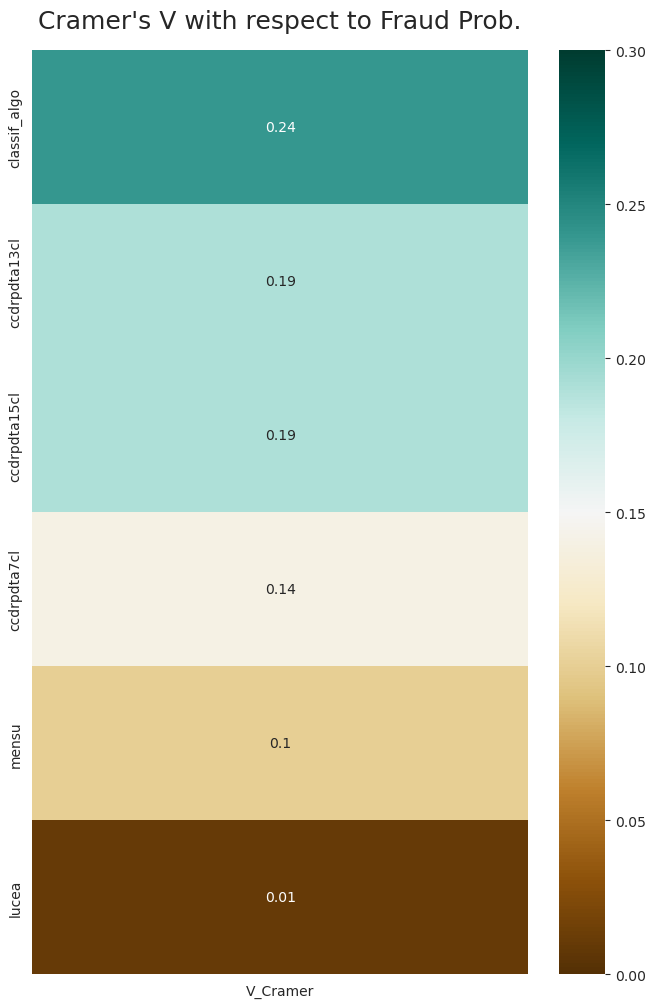

In [69]:
plt.figure(figsize = (8,12)) 
with sns.axes_style("white"):
    ax = sns.heatmap(df_cat_cramer.sort_values(by='V_Cramer', ascending=False), vmin=0., vmax=0.3,  cmap="BrBG", annot=True)
    ax.set_title("Cramer's V with respect to Fraud Prob.", fontdict={'fontsize':18}, pad=16);

In [70]:
seuil_selection = 0.1
var_Xobject_selected_Vcramer = df_cat_cramer.index[np.where(df_cat_cramer['V_Cramer'] > seuil_selection)[0]]
print(len(var_Xobject_selected_Vcramer))
print(var_Xobject_selected_Vcramer)

4
Index(['ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl', 'classif_algo'], dtype='object')


## Selection of candidate variables <a id='section_6.3'></a>

In [71]:
var_Xnum_selected_Fraude = var_Xnum_selected_kruskall
var_Xobject_selected_Fraude = var_Xobject_selected_khi2.append(var_Xobject_selected_Vcramer).drop_duplicates(keep='first')

In [72]:
var_Xobject_selected_Fraude

Index(['mensu', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl', 'classif_algo'], dtype='object')

Fraude
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: mensu, dtype: object

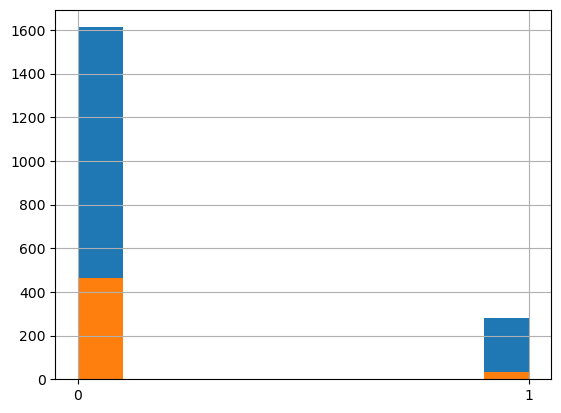

In [73]:
j = 0 #variable mensu
var_to_plot = var_Xobject_selected_Fraude[j]
Data_SISAL_Xobject_Y.groupby(target)[var_to_plot].hist(density=False)

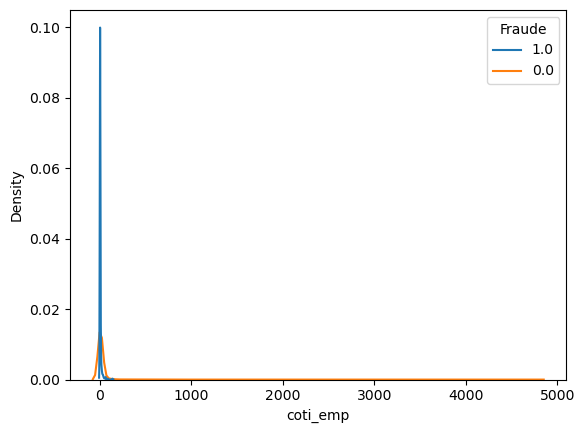

In [74]:
var_to_plot = 'coti_emp'
sns.kdeplot(x=var_to_plot,data=Data_SISAL_Xnum_Y, hue=target, common_norm=False);

# Step 5: Selection of explanatory variables for the adjustment amount <a id='section_7'></a>

*[Back to Table of Contents](#section_0)*

In [75]:
target = 'Montants'

## X Quanti - Y Quanti (Correlation Test) <a id='section_7.1'></a>

In [76]:
# Nous ajoutons la target à notre sélection de variables
Temp_selection = Temp_selection_num.append(pd.Index([target]))
# Correlation of Independent Variables with the Dependent Variable
Data_SISAL_Xnum_Y = Data_SISAL_annual[Temp_selection]
# Vérification de la dimension, c'est ok
Data_SISAL_Xnum_Y.shape

(162390, 40)

### Correlation test

<div class="alert alert-info">

On réalise le test suivant : 
$\displaystyle \begin{cases}
H_{0} \ :\ \rho _{s} = 0 \Leftrightarrow \mbox{  pas de corrélation entre les 2 variables.}\\
H_{1} \ :\ \rho _{s} \neq 0 \Leftrightarrow \mbox{  corrélation entre les 2 variables.}
\end{cases}$

Soit $\displaystyle t $ la statistique de test :

$\displaystyle t=\ \sqrt{n-2} \times \sqrt{\frac{\widehat{\rho}_{s}^{2}}{1-\widehat{\rho}_{s}^{2}}} \sim \ Student\ _{( n-2)} $

où $\widehat{\rho}_{s}$ est un estimateur sans biais et convergent de la corrélation. Le coefficient de corrélation de Pearson, Spearman ou Kendall peut être utilisé. 

</div>

In [77]:
# Le choix de la méthode de cacul de la corrélation impacte tout le notebook
method = "pearson"

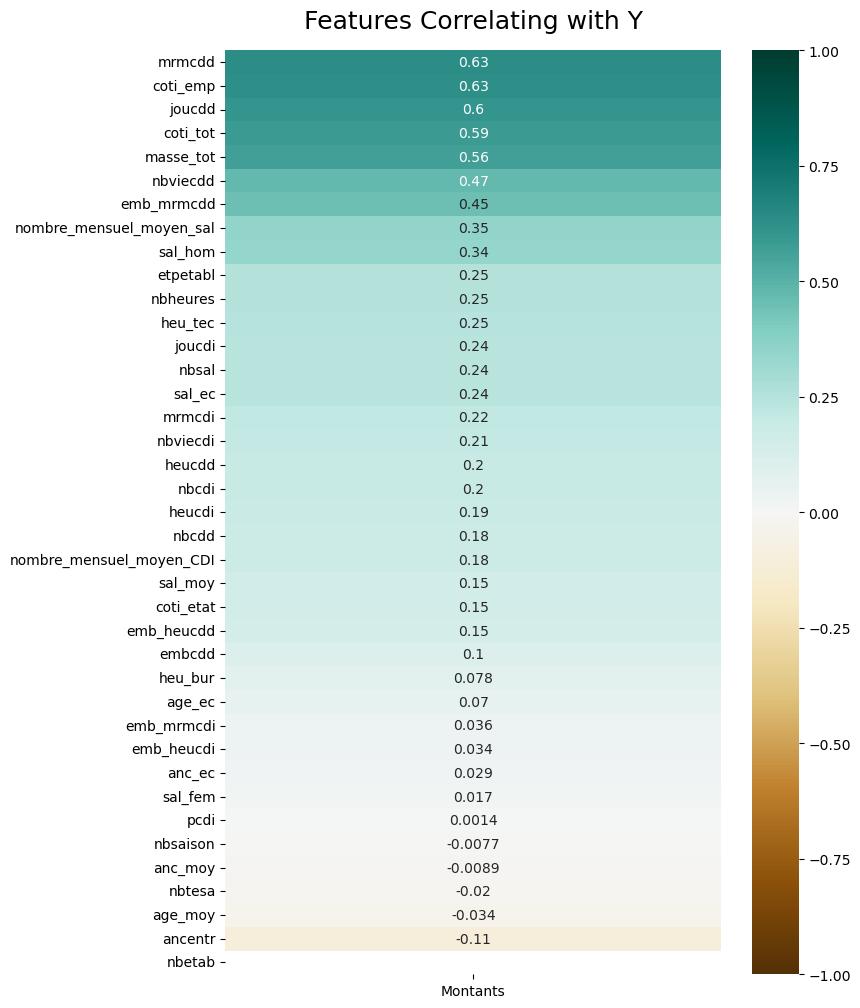

In [78]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(Data_SISAL_Xnum_Y.corr(method=method.lower())[[target]].sort_values(by=target, ascending=False)[1:], vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Y', fontdict={'fontsize':18}, pad=16);

In [79]:
def coeff_corr_test(var1, var2, method) :
    if method.lower() == "pearson":
        coeff_corr, p_value = pearsonr(var1, var2) # Corrélation linéaire de Pearson
        return [coeff_corr, p_value]
    elif method.lower() == "spearman":
        coeff_corr, p_value = spearmanr(var1, var2) # Corrélation de rang (non linéaire) mais pouvant être décrite par une fonction monotone
        return [coeff_corr, p_value]
    elif method.lower() == "kendall":
        coeff_corr, p_value = kendalltau(var1, var2) # Corrélation de rang
        return [coeff_corr, p_value]

In [80]:
# Bouclage sur chaque paire unique de variables numériques (sans redondance)

stock = []
for i in range(len(Temp_selection_num)):
    # il faut enlever les NaNs pour effectuer les tests de corrélation, d'où le df_temp
    df_temp = Data_SISAL_Xnum_Y[Data_SISAL_Xnum_Y[Temp_selection_num[i]].notna()]
    df_temp = df_temp[df_temp[target].notna()]
    row = [Temp_selection_num[i], target, coeff_corr_test(df_temp[Temp_selection_num[i]], df_temp[target], method)[:2]]
    stock.append(row)

print(stock)

test = pd.DataFrame(columns = ["coeff_corr", "p_value"])

for row in stock :
    test.loc[row[0], :] = [row[2][0], row[2][1]]
    
test.sort_values("p_value", ascending = True)

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[['ancentr', 'Montants', [-0.10685007259509798, 0.01729017655232253]], ['nbtesa', 'Montants', [-0.01983494846261248, 0.6594489715960778]], ['pcdi', 'Montants', [0.0013903554865357035, 0.9753599962640289]], ['age_moy', 'Montants', [-0.03416918962919424, 0.4476816753500132]], ['age_ec', 'Montants', [0.06960844565270206, 0.1215691810890358]], ['anc_moy', 'Montants', [-0.008914096735263898, 0.8430220648411713]], ['anc_ec', 'Montants', [0.02873273779049303, 0.5231965872862417]], ['sal_moy', 'Montants', [0.15356833135350173, 0.0005994172901781207]], ['sal_ec', 'Montants', [0.23692377059923408, 9.323561018034637e-08]], ['nombre_mensuel_moyen_sal', 'Montants', [0.3453956751610924, 2.4156678446033975e-15]], ['nombre_mensuel_moyen_CDI', 'Montants', [0.17598848248083968, 8.136075048331252e-05]], ['etpetabl', 'Montants', [0.25230563670695, 1.2167276088309717e-08]], ['nbetab', 'Montants', [nan, nan]], ['nbcdi', 'Montants', [0.19796529122357104, 8.920663655744008e-06]], ['nbcdd', 'Montants', [0.1786

,coeff_corr,p_value
mrmcdd,0.634789,0.0
coti_emp,0.632784,0.0
joucdd,0.604107,0.0
coti_tot,0.585218,0.0
masse_tot,0.564567,0.0
nbviecdd,0.47376,0.0
emb_mrmcdd,0.447384,0.0
nombre_mensuel_moyen_sal,0.345396,0.0
sal_hom,0.338634,0.0
etpetabl,0.252306,0.0


In [81]:
seuil_selection = 0.05
var_Xnum_selected_corr = test.index[np.where(test.p_value < seuil_selection)[0]]
print(len(var_Xnum_selected_corr))
print(var_Xnum_selected_corr)

27
Index(['ancentr', 'sal_moy', 'sal_ec', 'nombre_mensuel_moyen_sal',
       'nombre_mensuel_moyen_CDI', 'etpetabl', 'nbcdi', 'nbcdd', 'heucdi',
       'mrmcdi', 'joucdi', 'heucdd', 'mrmcdd', 'joucdd', 'nbheures', 'heu_tec',
       'nbsal', 'sal_hom', 'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat',
       'coti_emp', 'embcdd', 'emb_mrmcdd', 'emb_heucdd', 'coti_tot'],
      dtype='object')


In [82]:
test_corr_save = test

## X Quali - Y Quanti (Kruskall - Wallis Test) <a id='section_7.2'></a>

In [83]:
# We add the target
Temp_selection = Temp_selection_object.append(pd.Index([target]))
# Correlation of Independent Variables with the Dependent Variable
Data_SISAL_Xobject_Y = Data_SISAL_annual[Temp_selection]
# Check dimension, it is ok
Data_SISAL_Xobject_Y.shape

(162390, 7)

In [84]:
# Looping over each unique pair of categorical variables (without redundancy)

stock = []
for i in range(len(Temp_selection_object)):
    row = [Temp_selection_object[i], target, kruskal(*[group[target].values for name, group in Data_SISAL_Xobject_Y.groupby(Temp_selection_object[i])], nan_policy = 'omit')[:2]]
    stock.append(row)

print(stock)

test = pd.DataFrame(columns = ["Stat_Kruskall", "p_value"])

for row in stock :
    test.loc[row[0], :] = [row[2][0], row[2][1]]
    
test.sort_values("p_value", ascending = True)

[['lucea', 'Montants', (0.9904884335578318, 0.3196230263646589)], ['mensu', 'Montants', (7.109924441566713, 0.007665834077690089)], ['ccdrpdta7cl', 'Montants', (nan, nan)], ['ccdrpdta13cl', 'Montants', (nan, nan)], ['ccdrpdta15cl', 'Montants', (nan, nan)], ['classif_algo', 'Montants', (54.831980534738456, 1.3604493152839468e-05)]]


,Stat_Kruskall,p_value
classif_algo,54.831981,0.000014
mensu,7.109924,0.007666
lucea,0.990488,0.319623
ccdrpdta7cl,NaN,NaN
ccdrpdta13cl,NaN,NaN
ccdrpdta15cl,NaN,NaN


Ici, il nous faut de la granularité fine pour expliquer les montants dans les secteurs. On va sans doute travailler avec du 15 secteurs.

In [85]:
seuil_selection = 0.05
var_Xobject_selected_kruskall = test.index[np.where(test.p_value < seuil_selection)[0]]
print(len(var_Xobject_selected_kruskall))
print(var_Xobject_selected_kruskall)

2
Index(['mensu', 'classif_algo'], dtype='object')


## X Quali - Y Quali (Khi-2 Test) <a id='section_7.3'></a>

In [86]:
label = preprocessing.LabelEncoder() # Transformation des modalités de variables catégorielles en  modalités 0, 1, 2 ..
data_encoded = pd.DataFrame()  # DataFrame vide (A remplir)
Data_SISAL_Xobject = Data_SISAL_annual[Temp_selection_object]

# Encoding (0,1,2,3 ...)
for i in Data_SISAL_Xobject.columns :
    data_encoded[i] = label.fit_transform(Data_SISAL_Xobject[i])

data_encoded.head()

,lucea,mensu,ccdrpdta7cl,ccdrpdta13cl,ccdrpdta15cl,classif_algo
0,0,0,3,12,14,18
1,0,0,3,12,14,18
2,0,0,3,12,14,18
3,0,0,3,12,14,18
4,0,0,3,12,14,18


In [87]:
data_encoded.shape

(162390, 6)

In [88]:
# Calculate decile ranges
deciles = pd.qcut(Data_SISAL_annual[Data_SISAL_annual[target].notna()][target], q=10, labels=False, duplicates='drop')
# Assign categorical labels based on decile ranges
labels = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10']
categories = pd.Series(labels)[deciles].values
# Decile values
deciles_values = pd.qcut(Data_SISAL_annual[Data_SISAL_annual[target].notna()][target], q=10).value_counts()
print(deciles_values)

# Name of the new target
target_cat = 'target_categories'
Temp = pd.DataFrame({'target': Data_SISAL_annual[Data_SISAL_annual[target].notna()][target], target_cat: categories})
print(Temp.groupby(target_cat).count())
print(pd.DataFrame(Temp))

(0.00081, 0.335]      50
(0.335, 1.114]        50
(2.665, 5.11]         50
(9.15, 13.747]        50
(19.149, 33.695]      50
(63.727, 1509.346]    50
(1.114, 2.665]        49
(5.11, 9.15]          49
(13.747, 19.149]      49
(33.695, 63.727]      49
Name: Montants, dtype: int64
                   target
target_categories        
D01                    50
D02                    50
D03                    49
D04                    50
D05                    49
D06                    50
D07                    49
D08                    50
D09                    49
D10                    50
            target target_categories
8        40.405563               D09
623      66.979312               D10
724       1.466187               D03
772       2.415687               D03
865       0.036125               D01
...            ...               ...
161589    0.285719               D01
161723   96.098344               D10
161761  501.127187               D10
162171    9.661844               D06
16

In [89]:
# merge the dataframes by index
data_encoded = pd.merge(data_encoded, Data_SISAL_annual[target], left_index=True, right_index=True, how='left')
data_encoded = pd.merge(data_encoded, Temp[target_cat], left_index=True, right_index=True, how='left')
# add target_cat in Data_SISAL_annual
Data_SISAL_annual = pd.merge(Data_SISAL_annual, Temp[target_cat], left_index=True, right_index=True, how='left')

In [90]:
# we drop column target (which is numeric) to do some computation
data_encoded = data_encoded.drop([target], axis='columns')

In [91]:
data_encoded.dtypes

lucea                 int32
mensu                 int32
ccdrpdta7cl           int32
ccdrpdta13cl          int32
ccdrpdta15cl          int32
classif_algo          int32
target_categories    object
dtype: object

In [92]:
data_encoded = data_encoded[data_encoded[target_cat].isin(labels)]

In [93]:
print(data_encoded.shape)
data_encoded.head()

(496, 7)


,lucea,mensu,ccdrpdta7cl,ccdrpdta13cl,ccdrpdta15cl,classif_algo,target_categories
8,0,1,3,12,14,18,D09
623,0,0,3,3,4,7,D10
724,0,0,3,12,14,18,D03
772,0,0,3,12,14,18,D03
865,0,0,3,5,6,11,D01


### Test Khi deux

In [94]:
# Fonction Test chi deux

def chi_deux(var1, var2) :
    # Tableau de contingence
    crosstab = np.array(pd.crosstab(var1, var2, rownames = None, colnames = None, dropna=True,))
    # Test du Chi deux
    stat, pvalue , dof, expected = chi2_contingency(crosstab) # On demande la p value
    return [stat, pvalue, dof, expected]

# chi_deux(data_encoded['lucea'], data_encoded[target_cat])[:2] # stat en première position et la p_value en deuxième

In [95]:
# Bouclage sur chaque paire unique de variables catégorielles (sans redondance)
stock = []
for i in range(len(Temp_selection_object)):
    row = [data_encoded.columns[i], target_cat, chi_deux(data_encoded[data_encoded.columns[i]], data_encoded[target_cat])[:2]]
    stock.append(row)

print(stock) # Résultat : une liste de liste contenant pour chaque paire la valeur de la stat et la p-value associée

[['lucea', 'target_categories', [8.938020202020203, 0.44301507242415294]], ['mensu', 'target_categories', [16.68349753694581, 0.05390930821124175]], ['ccdrpdta7cl', 'target_categories', [73.77311382950337, 0.00020826484289515325]], ['ccdrpdta13cl', 'target_categories', [141.0941216398336, 0.0004700797973949275]], ['ccdrpdta15cl', 'target_categories', [152.71806721806487, 0.0004303094315902915]], ['classif_algo', 'target_categories', [212.98833760944063, 0.00444097492155845]]]


In [96]:
test = pd.DataFrame(columns = ["stat", "p_value"])

for row in stock :
    test.loc[row[0], :] = [row[2][0], row[2][1]]
    
test.sort_values("stat", ascending = False)

,stat,p_value
classif_algo,212.988338,0.004441
ccdrpdta15cl,152.718067,0.00043
ccdrpdta13cl,141.094122,0.00047
ccdrpdta7cl,73.773114,0.000208
mensu,16.683498,0.053909
lucea,8.93802,0.443015


In [97]:
seuil_selection = 0.05
var_Xobject_selected_khi2 = test.index[np.where(test.p_value < seuil_selection)[0]]
print(len(var_Xobject_selected_khi2))
print(var_Xobject_selected_khi2)

4
Index(['ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl', 'classif_algo'], dtype='object')


## Selection of candidate variables <a id='section_7.4'></a>

In [98]:
var_Xnum_selected_Montants = var_Xnum_selected_corr
var_Xobject_selected_Montants = var_Xobject_selected_kruskall.append(var_Xobject_selected_khi2).drop_duplicates(keep='first')

# Step 6: Analysis of multicollinearity <a id='section_8'></a>

*[Back to Table of Contents](#section_0)*

If a variable appears at least once to explain `Fraud` or `Amounts` then we keep it as candidates.

In [99]:
var_Xnum_selected = var_Xnum_selected_Fraude.append(var_Xnum_selected_Montants).drop_duplicates(keep='first')
print(len(var_Xnum_selected))
print(var_Xnum_selected)
print(Labels_X_SISAL.iloc[0][var_Xnum_selected].to_list())

37
Index(['ancentr', 'nbtesa', 'pcdi', 'age_ec', 'anc_moy', 'anc_ec', 'sal_moy',
       'sal_ec', 'nombre_mensuel_moyen_sal', 'nombre_mensuel_moyen_CDI',
       'etpetabl', 'nbcdi', 'nbcdd', 'nbsaison', 'heucdi', 'mrmcdi', 'joucdi',
       'heucdd', 'mrmcdd', 'joucdd', 'nbheures', 'heu_tec', 'heu_bur', 'nbsal',
       'sal_hom', 'sal_fem', 'masse_tot', 'nbviecdi', 'nbviecdd', 'coti_etat',
       'coti_emp', 'emb_mrmcdi', 'emb_heucdi', 'embcdd', 'emb_mrmcdd',
       'emb_heucdd', 'coti_tot'],
      dtype='object')
["Ancienneté de l'entreprise", 'Nombre de Tesa', '% salariés en CDI', "Ecart-type de l'âge du salarié", "Ancienneté moyenne du salarié au sein de l'entreprise", "Ecart_type de l'ancienneté du salarié", "Salaire moyen au sein de l'entreprise", "Ecart-type du salaire au sein de l'entreprise", 'Taille moyenne en salariés (moyenne mensuelle)', 'Nombre moyen mensuel de CDI', "Nb ETP dans l'entreprise", "Nombre de CDI ayant exercé au cours de l'année", "Nombre de CDD ayant exercé au

In [100]:
var_Xalpha_selected = var_Xobject_selected_Fraude.append(var_Xobject_selected_Montants).drop_duplicates(keep='first')
print(len(var_Xalpha_selected))
print(var_Xalpha_selected)
print(Labels_X_SISAL.iloc[0][var_Xalpha_selected].to_list())

5
Index(['mensu', 'ccdrpdta7cl', 'ccdrpdta13cl', 'ccdrpdta15cl', 'classif_algo'], dtype='object')
['MENSU', 'Cat. Risque prépondérant AT 7cl', 'Cat. Risque prépondérant AT 13cl', 'Cat. Risque prépondérant AT 15cl', 'Cat. Risque Algorithmique']


We only keep the observations where we had a check, that is to say the 2390 observations matched with the SISAL database, because our priority is to explain the fraud.

In [101]:
Data_SISAL_Xnum = Data_SISAL_annual[Data_SISAL_annual['Fraude_num'].notna()][var_Xnum_selected]
len(Data_SISAL_Xnum)

2390

## Cross-correlation analysis <a id='section_8.1'></a>

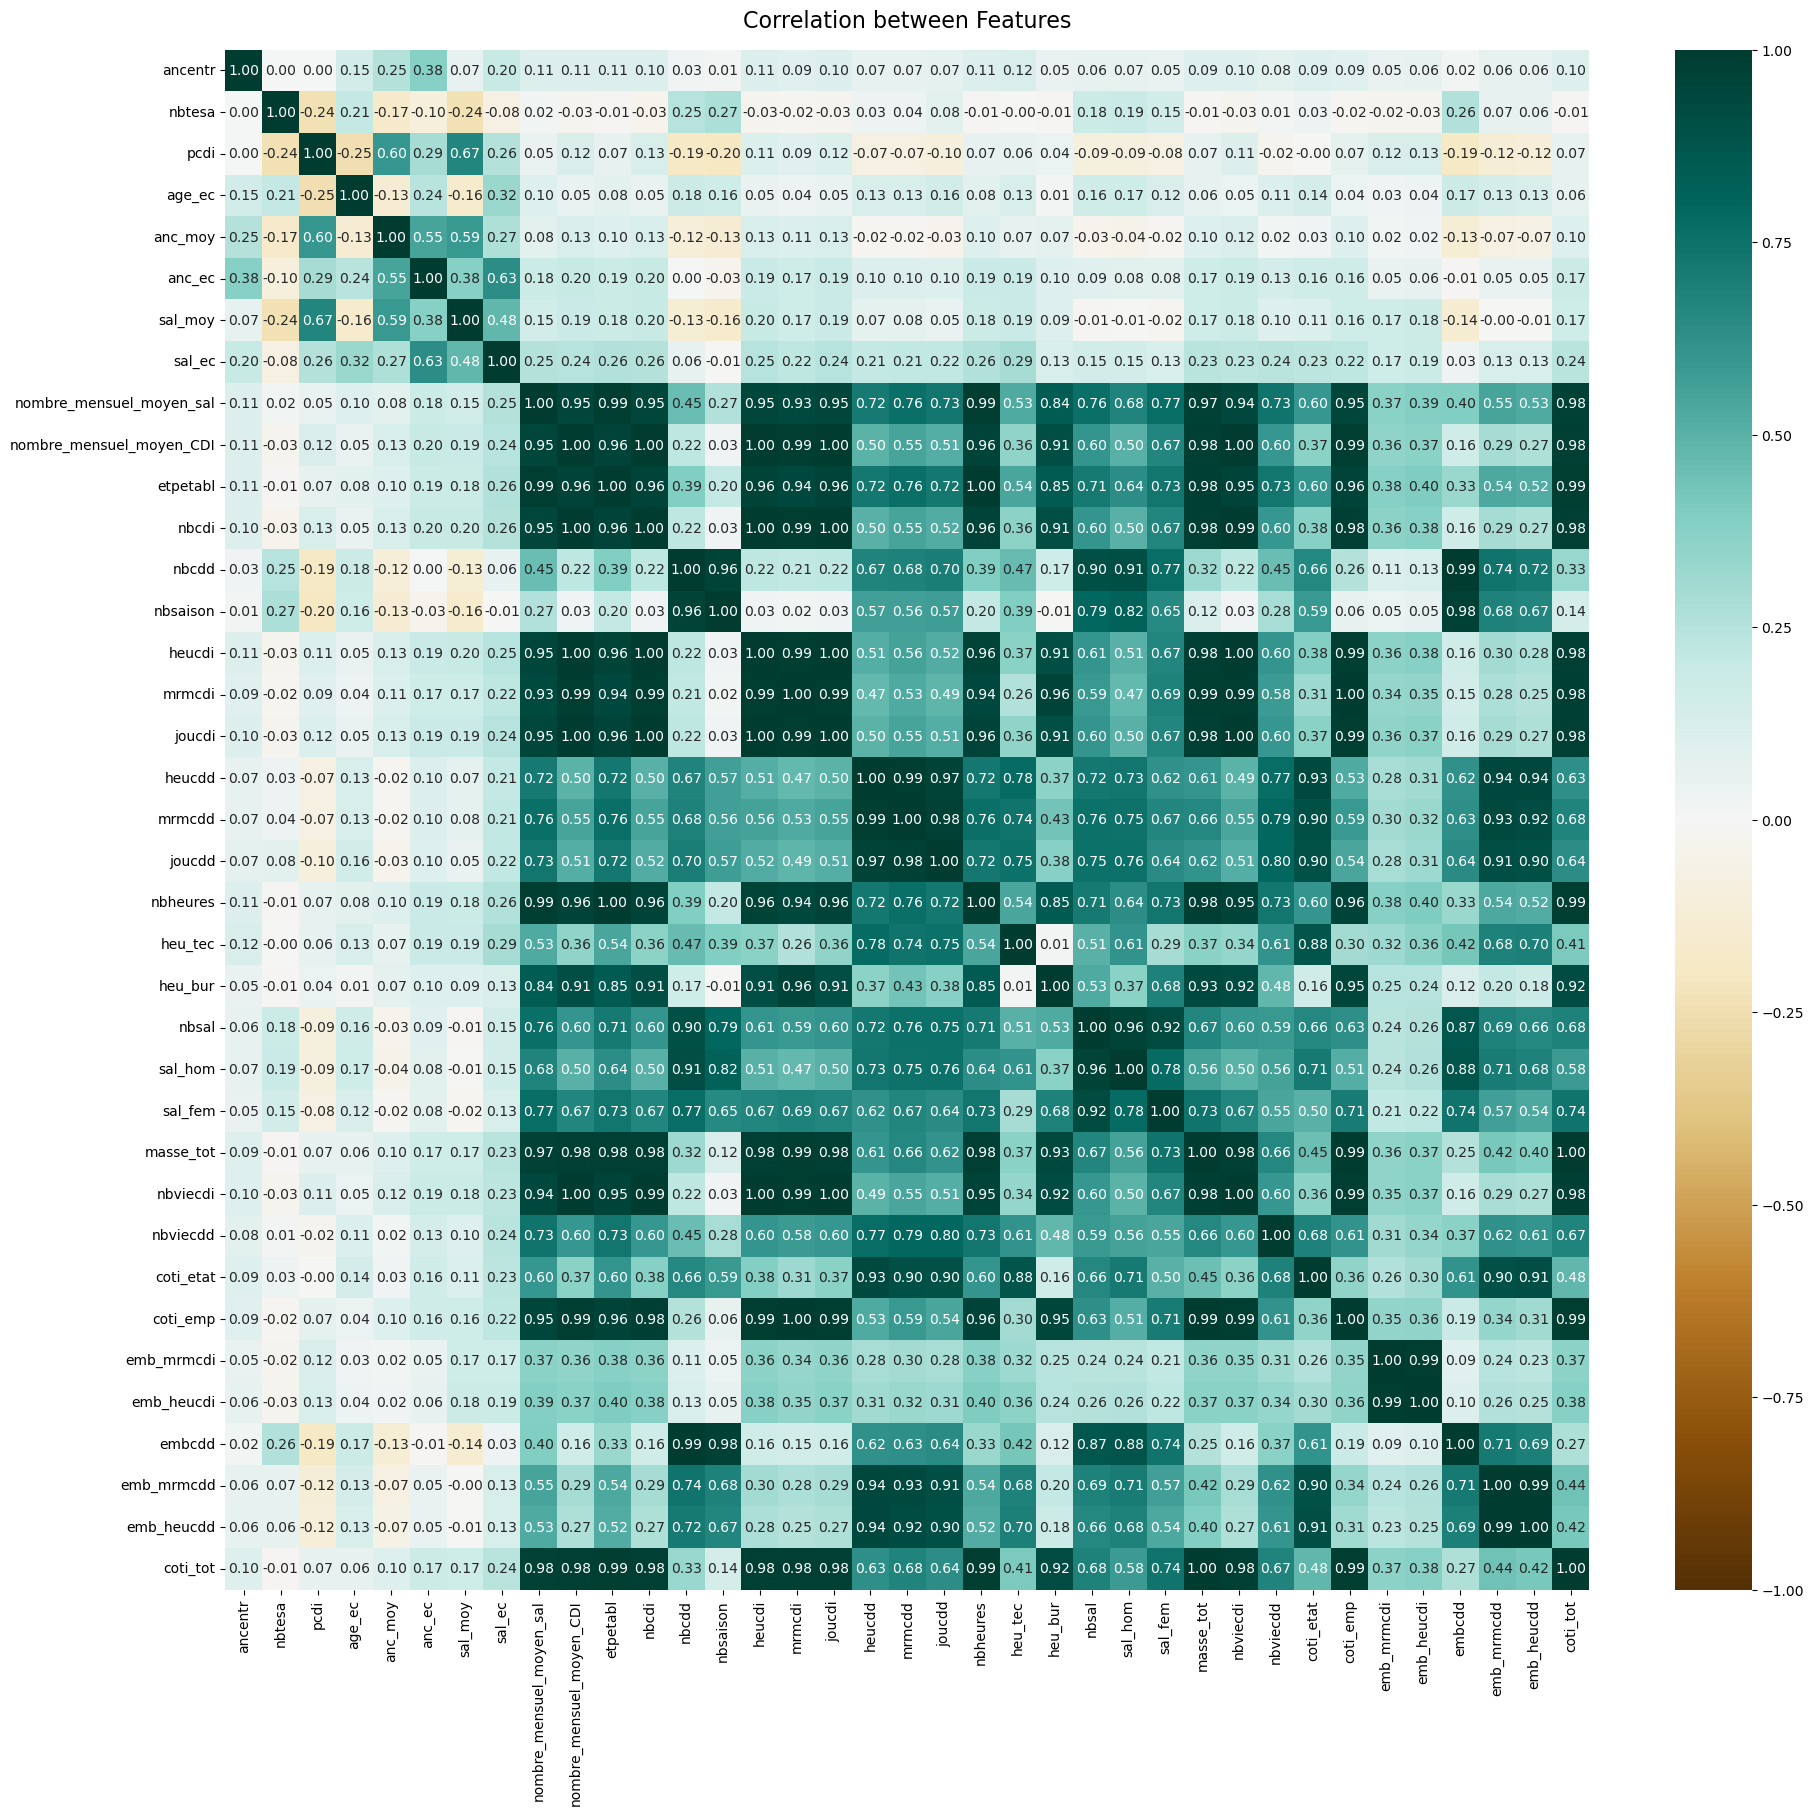

In [102]:
Data_SISAL_Xnum_corr = Data_SISAL_Xnum.corr(method=method)
plt.figure(figsize=(22, 20))
heatmap = sns.heatmap(Data_SISAL_Xnum_corr, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt='.2f')
heatmap.set_title('Correlation between Features', fontdict={'fontsize':16}, pad=16);

In [103]:
# Bouclage sur chaque paire unique de variables numériques (sans redondance) afin de sauvegarder ces corrélations croisées dans un df

stock = []
test_to_select = pd.DataFrame()
for i in range(len(Data_SISAL_Xnum.columns)):
    for j in range(i + 1, len(Data_SISAL_Xnum.columns)):
        row = [Data_SISAL_Xnum.columns[i], Data_SISAL_Xnum.columns[j], coeff_corr_test(Data_SISAL_Xnum[Data_SISAL_Xnum.columns[i]], Data_SISAL_Xnum[Data_SISAL_Xnum.columns[j]], method)[:2]]
        stock.append(row)
        test_to_select = pd.concat([test_to_select,pd.DataFrame([row[0] , row[1] , row[2][0], row[2][1]]).T])

test_to_select.columns = ["x1", "x2", "coeff_corr", "p_value"]
# print(stock)

test = pd.DataFrame(columns = ["coeff_corr", "p_value"])

for row in stock :
    test.loc[row[0] + " - "+ row[1], :] = [row[2][0], row[2][1]]
    
# test.sort_values("coeff_corr", ascending = False)

We propose to keep the explanatory variables having cross-correlations smaller than a certain threshold and then we will study the variables having cross-correlations greater than this threshold. In the latter case, we will prefer to keep the variables most correlated to the target (here the `Fraud Amounts`, > 0).

In [104]:
seuil_selection = 0.90

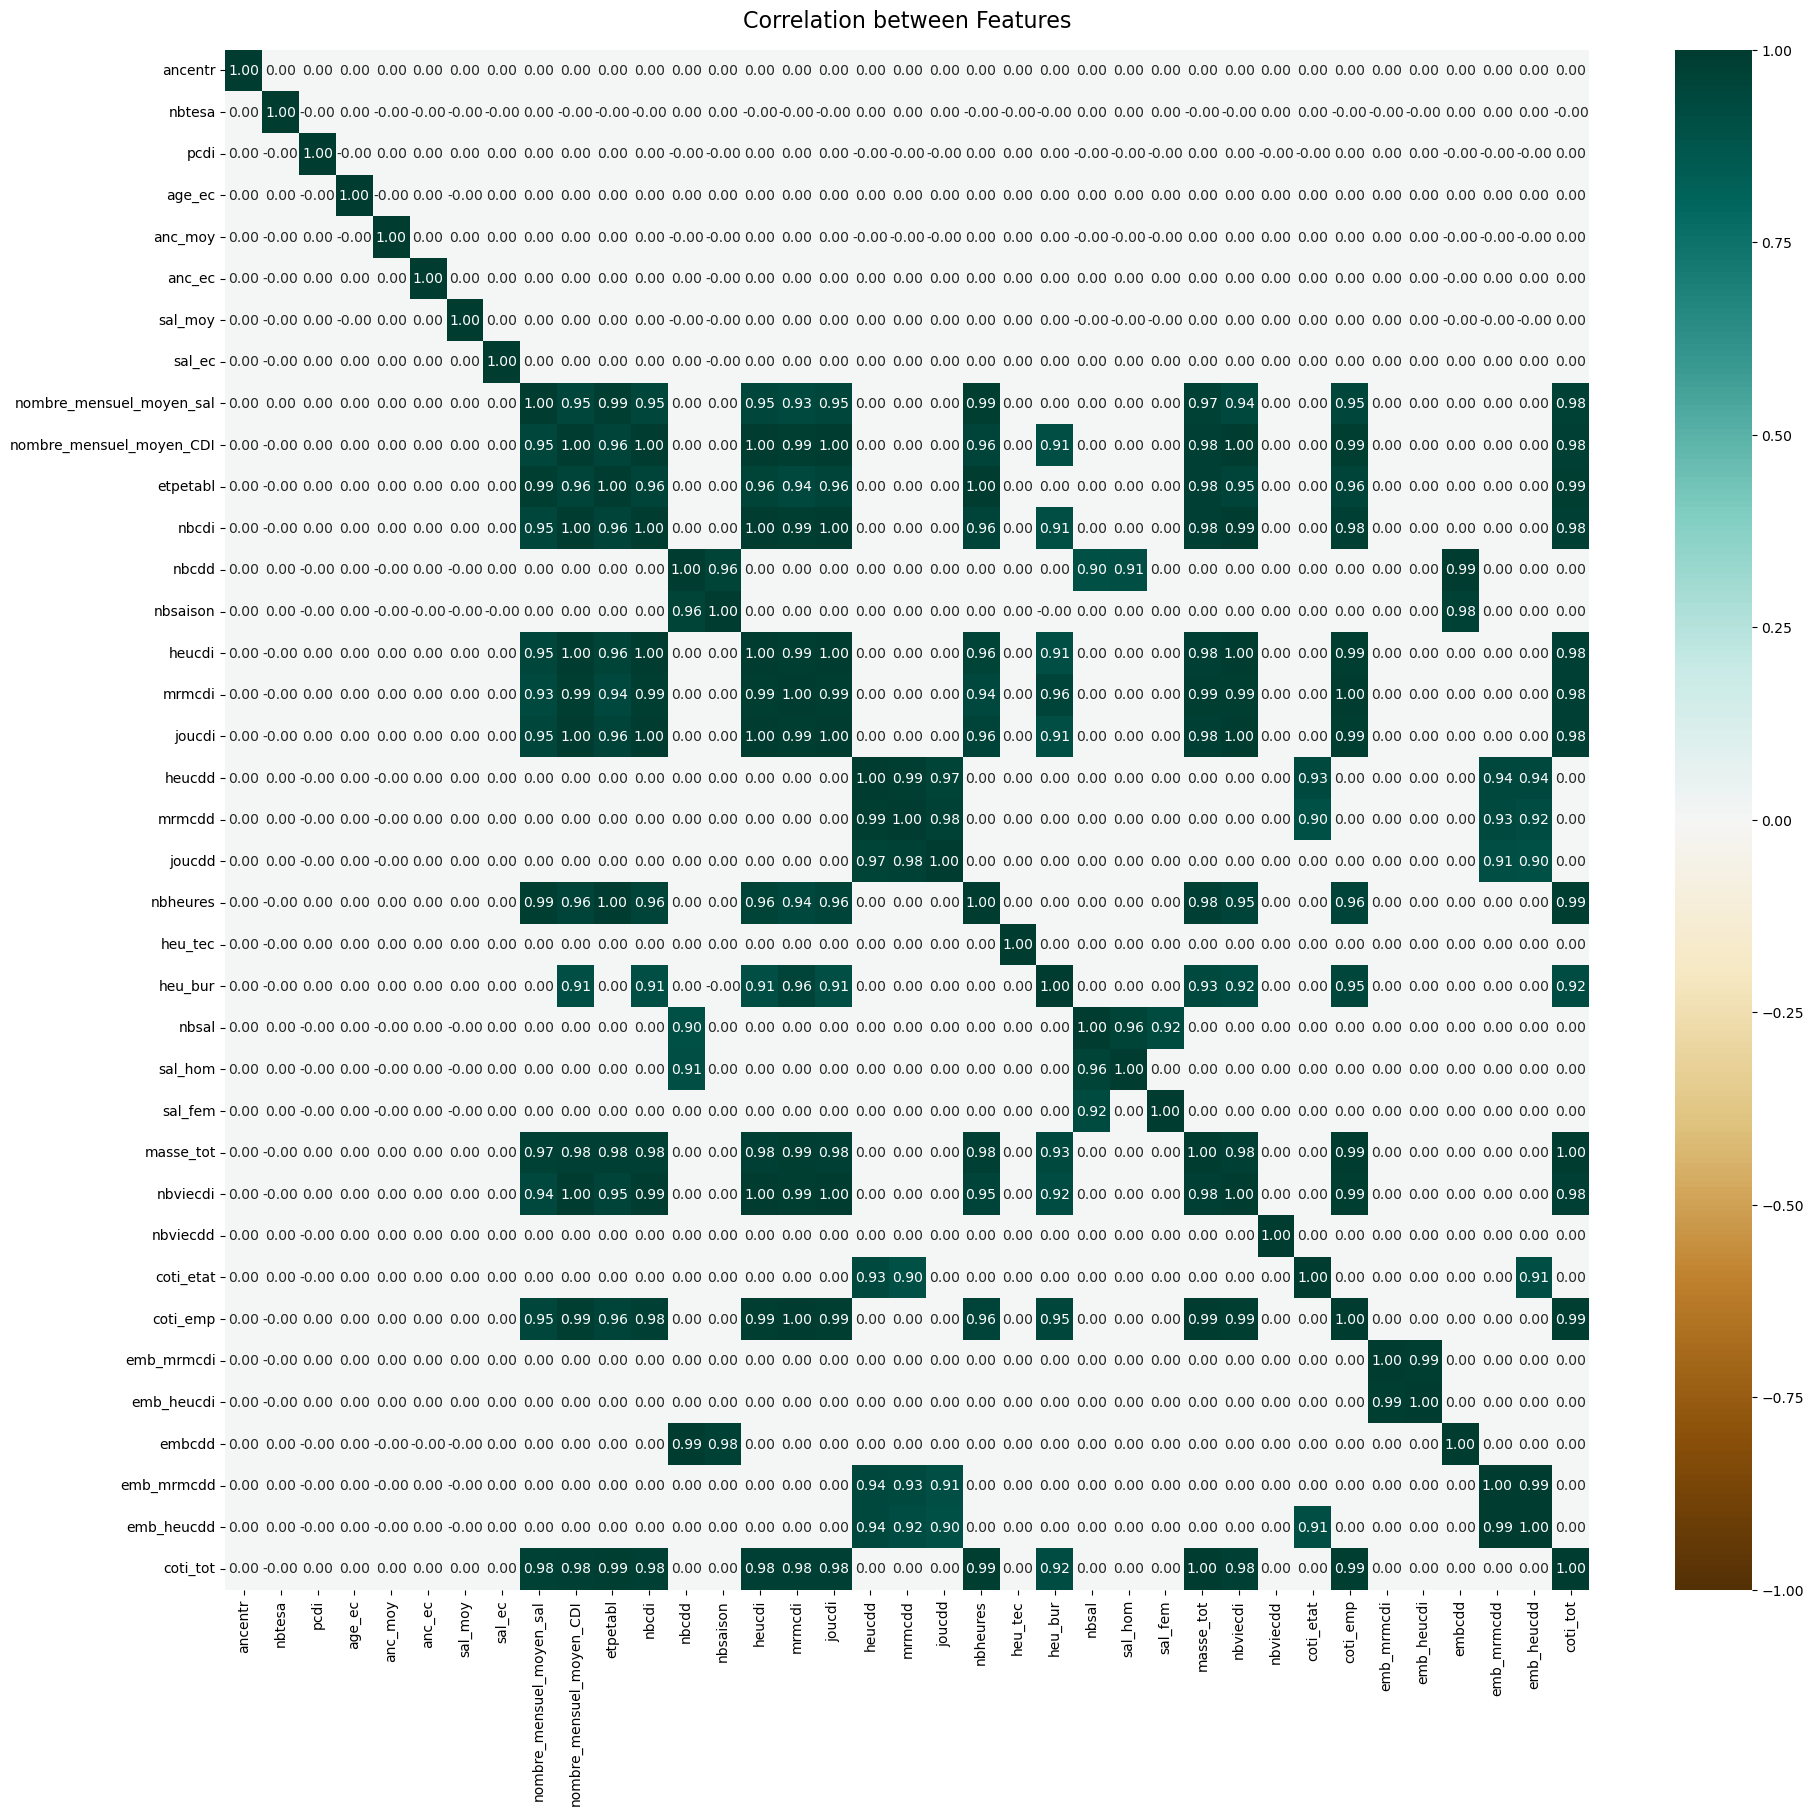

In [105]:
plt.figure(figsize=(22, 20))
heatmap = sns.heatmap(Data_SISAL_Xnum_corr*(Data_SISAL_Xnum_corr > seuil_selection), vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt='.2f')
heatmap.set_title('Correlation between Features', fontdict={'fontsize':16}, pad=16);

In [106]:
print(f"The number of problematic cross-correlation is equal to {int(((Data_SISAL_Xnum_corr > seuil_selection).sum().sum() - len(Data_SISAL_Xnum_corr))/2)} et sont reportées ci-dessous:")
print(test[test.coeff_corr > seuil_selection].sort_index())
pairs_to_check = test.index[np.where(test.coeff_corr > seuil_selection)[0]]
# pairs_to_check

The number of problematic cross-correlation is equal to 96 et sont reportées ci-dessous:
                                                   coeff_corr p_value
coti_emp - coti_tot                                  0.991401     0.0
coti_etat - emb_heucdd                               0.907658     0.0
emb_mrmcdd - emb_heucdd                              0.994931     0.0
emb_mrmcdi - emb_heucdi                              0.989377     0.0
etpetabl - coti_emp                                  0.957815     0.0
...                                                       ...     ...
nombre_mensuel_moyen_sal - mrmcdi                     0.93139     0.0
nombre_mensuel_moyen_sal - nbcdi                     0.945649     0.0
nombre_mensuel_moyen_sal - nbheures                  0.986222     0.0
nombre_mensuel_moyen_sal - nbviecdi                   0.94332     0.0
nombre_mensuel_moyen_sal - nombre_mensuel_moyen...   0.947882     0.0

[96 rows x 2 columns]


## Selection of our numerical variables by dendogram and link to the target <a id='section_8.2'></a>

In [107]:
# Set the correlation threshold
threshold_for_cluster_creation = 1 - seuil_selection

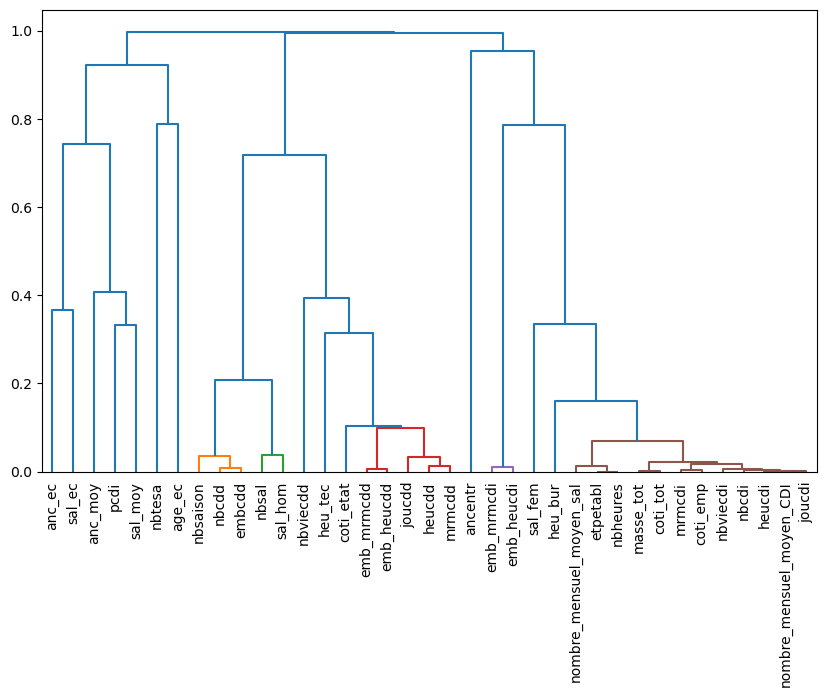

In [108]:
# We convert the correlation matrix to a distance matrix before performing hierarchical clustering using Ward's linkage.
distance_matrix = squareform(1 - np.abs(Data_SISAL_Xnum_corr))
dist_linkage = hierarchy.complete(distance_matrix) #each row of the resulting array has the format [idx1, idx2, dist, sample_count].
plt.figure(figsize=(10, 6))
dendro = hierarchy.dendrogram(dist_linkage, labels = Data_SISAL_Xnum_corr.columns.tolist(), leaf_rotation=90, color_threshold=threshold_for_cluster_creation)
plt.xticks(fontsize=10)
plt.show()

In [109]:
# Retrieving clusters (in colors above) from the hierarchy
cluster_ids = hierarchy.fcluster(dist_linkage, threshold_for_cluster_creation, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
clusters = [ list(v) for v in cluster_id_to_feature_ids.values() if len(v) >1]
clusters_col = [list(Data_SISAL_Xnum.columns[v]) for v in clusters]
clusters_col

[['nombre_mensuel_moyen_sal',
  'nombre_mensuel_moyen_CDI',
  'etpetabl',
  'nbcdi',
  'heucdi',
  'mrmcdi',
  'joucdi',
  'nbheures',
  'masse_tot',
  'nbviecdi',
  'coti_emp',
  'coti_tot'],
 ['nbcdd', 'nbsaison', 'embcdd'],
 ['heucdd', 'mrmcdd', 'joucdd', 'emb_mrmcdd', 'emb_heucdd'],
 ['nbsal', 'sal_hom'],
 ['emb_mrmcdi', 'emb_heucdi']]

For each cluster, we select the variable most linked to the `Fraud` target (Kruskall-Wallis test)

In [110]:
var_Xnum_selected_final = var_Xnum_selected
for i in range(len(clusters_col)):
    var_Xnum_selected_final = var_Xnum_selected_final.drop(pd.Index(clusters_col[i]))
    selected_var_cluster = kruskall_save_Fraude[kruskall_save_Fraude['Stat_Kruskall'] == max(kruskall_save_Fraude.loc[clusters_col[i],'Stat_Kruskall'])].index
    var_Xnum_selected_final = var_Xnum_selected_final.append(selected_var_cluster)
    print(selected_var_cluster)

Index(['nombre_mensuel_moyen_sal'], dtype='object')
Index(['nbsaison'], dtype='object')
Index(['emb_heucdd'], dtype='object')
Index(['nbsal'], dtype='object')
Index(['emb_heucdi'], dtype='object')


In [111]:
print(len(var_Xnum_selected_final))
print(var_Xnum_selected_final)
Labels_X_SISAL[var_Xnum_selected_final].T

18
Index(['ancentr', 'nbtesa', 'pcdi', 'age_ec', 'anc_moy', 'anc_ec', 'sal_moy',
       'sal_ec', 'heu_tec', 'heu_bur', 'sal_fem', 'nbviecdd', 'coti_etat',
       'nombre_mensuel_moyen_sal', 'nbsaison', 'emb_heucdd', 'nbsal',
       'emb_heucdi'],
      dtype='object')


,0
Variable,
ancentr,Ancienneté de l'entreprise
nbtesa,Nombre de Tesa
pcdi,% salariés en CDI
age_ec,Ecart-type de l'âge du salarié
anc_moy,Ancienneté moyenne du salarié au sein de l'ent...
anc_ec,Ecart_type de l'ancienneté du salarié
sal_moy,Salaire moyen au sein de l'entreprise
sal_ec,Ecart-type du salaire au sein de l'entreprise
heu_tec,Nb heures technique


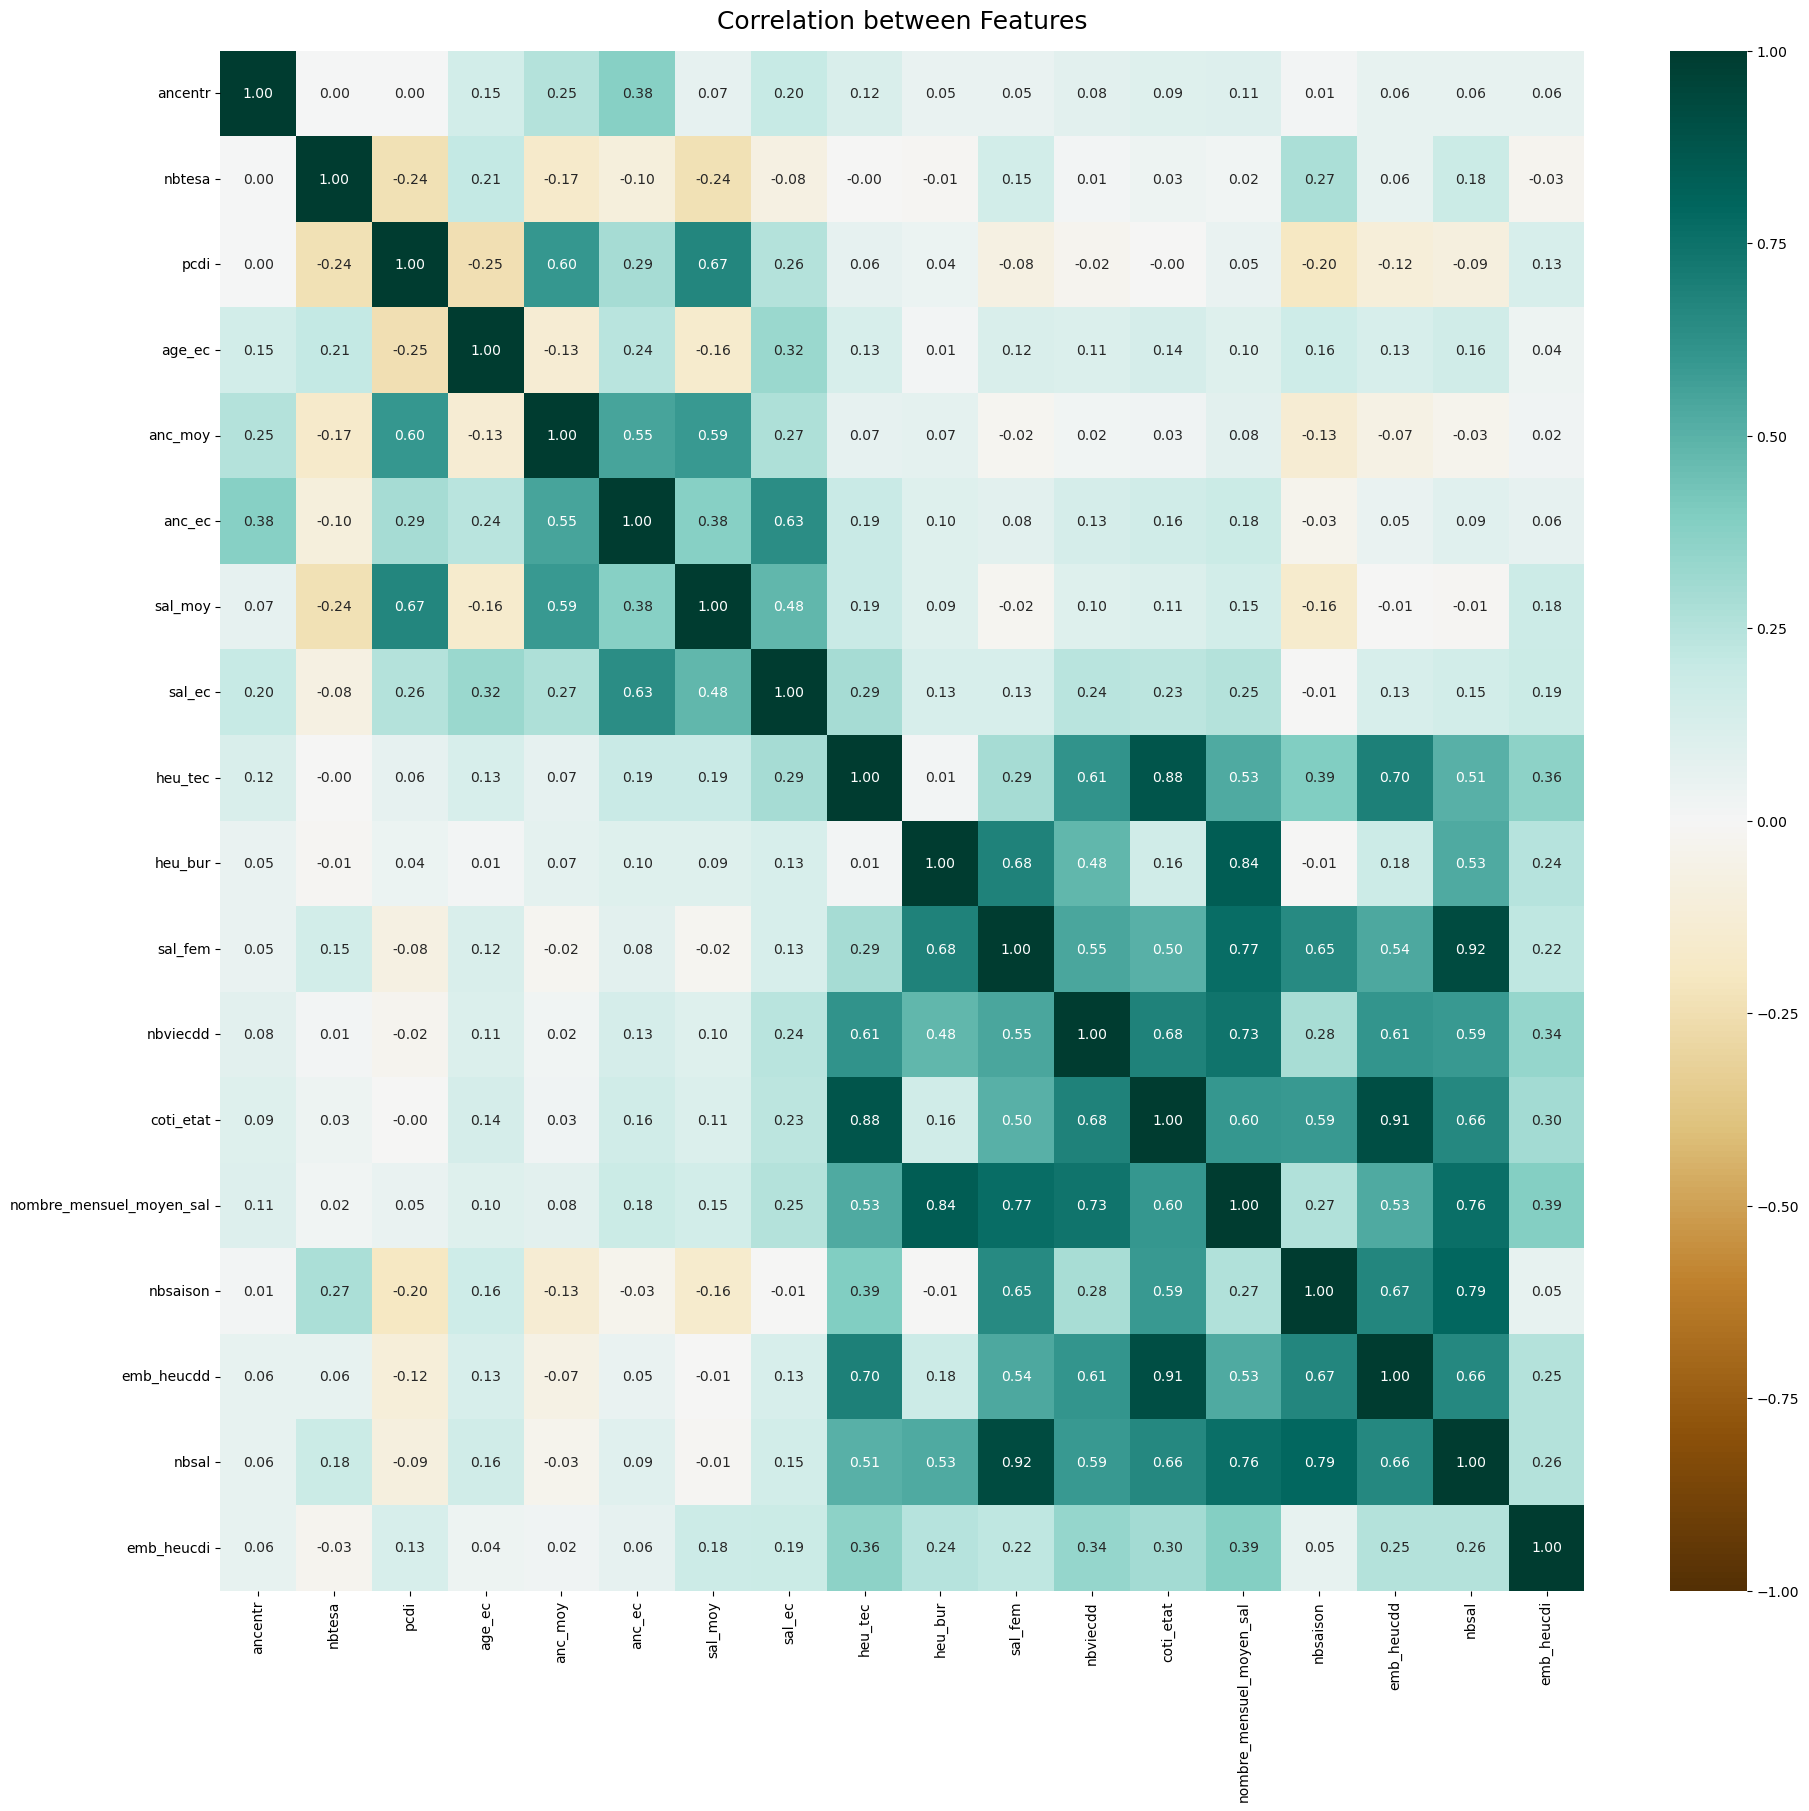

In [112]:
plt.figure(figsize=(22, 20))
heatmap = sns.heatmap(Data_SISAL_Xnum[var_Xnum_selected_final].corr(method=method), vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt='.2f')
heatmap.set_title('Correlation between Features', fontdict={'fontsize':18}, pad=16);

In [113]:
print(f"The number of problematic cross-correlation is now equal to {int(((Data_SISAL_Xnum[var_Xnum_selected_final].corr(method=method) > seuil_selection).sum().sum() - len(Data_SISAL_Xnum[var_Xnum_selected_final].corr(method=method)))/2)}.")

The number of problematic cross-correlation is now equal to 2.


# Step 7: Discretisation and final selection <a id='section_9'></a>

*[Back to Table of Contents](#section_0)*

In [114]:
Data_SISAL_Xnum_final_notna = Data_SISAL_annual[Data_SISAL_annual['Fraude_num'].notna()][var_Xnum_selected_final]
print(len(Data_SISAL_Xnum_final_notna))
Data_SISAL_Xnum_final_notna.head()

2390


,ancentr,nbtesa,pcdi,age_ec,anc_moy,anc_ec,sal_moy,sal_ec,heu_tec,heu_bur,sal_fem,nbviecdd,coti_etat,nombre_mensuel_moyen_sal,nbsaison,emb_heucdd,nbsal,emb_heucdi
8,15,15,0.044444,12.524623,0.333333,1.135292,2579.933333,3424.718197,10594,0,13,2,8.271653,13.916667,40,7092,40,0
32,14,15,0.000000,10.598532,0.000000,0.000000,4001.200000,1740.647588,4617,0,1,2,3.909575,2.750000,15,4617,9,0
66,14,7,0.000000,9.165151,0.000000,0.000000,179.857143,46.187285,92,17,1,0,0.082462,0.583333,7,109,7,0
463,11,0,0.000000,8.151346,0.111111,0.314270,485.555556,276.882290,459,0,3,1,0.383809,2.083333,9,429,7,0
623,7,0,0.111111,12.856281,1.666667,1.699673,5998.444444,4810.562363,5265,154,3,0,3.363116,-2.416667,1,377,8,0


In [115]:
Data_SISAL_Xnum_final_isna = Data_SISAL_annual[Data_SISAL_annual['Fraude_num'].isna()][var_Xnum_selected_final]
len(Data_SISAL_Xnum_final_isna)

160000

## Discretisation by quantiles <a id='section_9.1'></a>

In [116]:
Data_SISAL_Xnum_cat_final_notna = pd.DataFrame()
Data_SISAL_Xnum_cat_final_notna_for_merge = pd.DataFrame()
Data_SISAL_Xnum_cat_final_isna_for_merge = pd.DataFrame()
for i in range(len(var_Xnum_selected_final)):
    deciles = pd.qcut(Data_SISAL_Xnum_final_notna[Data_SISAL_Xnum_final_notna.columns[i]], q=10, labels=False, duplicates='drop')
    labels = ['D01', 'D02', 'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10']
    categories = pd.Series(labels)[deciles].values
    categories
    [deciles_bins, bins] = pd.qcut(Data_SISAL_Xnum_final_notna[Data_SISAL_Xnum_final_notna.columns[i]], q=10, duplicates='drop', retbins=True)
    bins[0] = -np.inf
    bins[-1] = np.inf
    print(bins)    
    # Decile values
    deciles_values = pd.qcut(Data_SISAL_Xnum_final_notna[Data_SISAL_Xnum_final_notna.columns[i]], q=10, duplicates='drop').value_counts()
    print(deciles_values)
    # Mettre les valeurs des deciles dans la base notna
    Data_SISAL_Xnum_cat_final_notna[Data_SISAL_Xnum_final_notna.columns[i]] = deciles
    Data_SISAL_Xnum_cat_final_notna_for_merge[Data_SISAL_Xnum_final_notna.columns[i]+'_deciles'] = deciles
    # Mettre ces valeurs des deciles dans la base isna
    Data_SISAL_Xnum_cat_final_isna_for_merge[Data_SISAL_Xnum_final_isna.columns[i]+'_deciles'] = pd.cut(Data_SISAL_Xnum_final_isna[Data_SISAL_Xnum_final_isna.columns[i]], bins=bins, labels=False)

[-inf   2.   5.   8.  11.  15.  18.  22.  25.  29.  inf]
(11.0, 15.0]     280
(-0.001, 2.0]    259
(2.0, 5.0]       257
(18.0, 22.0]     248
(5.0, 8.0]       235
(29.0, 84.0]     234
(15.0, 18.0]     231
(22.0, 25.0]     221
(25.0, 29.0]     218
(8.0, 11.0]      207
Name: ancentr, dtype: int64
[-inf   2.   6.  17.  inf]
(-0.001, 2.0]    1729
(17.0, 179.0]     234
(6.0, 17.0]       226
(2.0, 6.0]        201
Name: nbtesa, dtype: int64
[      -inf 0.02857143 0.07692308 0.16666667 0.33333333 0.5027027
 0.90519481        inf]
(-0.001, 0.0286]    957
(0.167, 0.333]      260
(0.0769, 0.167]     257
(0.0286, 0.0769]    239
(0.503, 0.905]      239
(0.905, 1.0]        239
(0.333, 0.503]      199
Name: pcdi, dtype: int64
[       -inf  3.73325834  7.74816276  9.75811618 11.10611108 12.25104869
 13.19977221 14.54589357 16.29136628         inf]
(-0.001, 3.733]     478
(3.733, 7.748]      239
(7.748, 9.758]      239
(9.758, 11.106]     239
(11.106, 12.251]    239
(12.251, 13.2]      239
(13.2, 14.546

In [117]:
Data_SISAL_Xnum_cat_final = pd.concat([Data_SISAL_Xnum_cat_final_notna_for_merge, Data_SISAL_Xnum_cat_final_isna_for_merge], sort=False).sort_index()
print(Data_SISAL_Xnum_cat_final.shape)
Data_SISAL_Xnum_cat_final

(162390, 18)


,ancentr_deciles,nbtesa_deciles,pcdi_deciles,age_ec_deciles,anc_moy_deciles,anc_ec_deciles,sal_moy_deciles,sal_ec_deciles,heu_tec_deciles,heu_bur_deciles,sal_fem_deciles,nbviecdd_deciles,coti_etat_deciles,nombre_mensuel_moyen_sal_deciles,nbsaison_deciles,emb_heucdd_deciles,nbsal_deciles,emb_heucdi_deciles
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4,1,0,8,2,1,1,1,1,0,0,2,2,1,2,2,1,0
2,4,0,0,0,6,0,4,0,1,0,0,0,2,0,0,0,0,0
3,4,1,0,5,0,0,1,1,0,0,0,1,1,0,1,1,0,0
4,4,3,1,4,3,3,3,4,6,0,4,2,7,6,5,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162385,5,0,4,0,5,3,5,3,2,0,0,0,2,2,0,0,0,1
162386,4,0,6,0,8,0,7,0,2,0,0,0,2,1,0,0,0,0
162387,4,0,0,0,5,0,5,0,3,0,0,0,2,2,0,0,0,0
162388,4,0,6,0,8,0,9,0,4,0,0,0,4,2,0,0,0,0


## Selection by analysis of target dependence (Cramer's V) <a id='section_9.2'></a>

In [118]:
# Add the target
target = 'Fraude'
# Correlation of Independent Variables with the Dependent Variable
Data_SISAL_Xnum_cat_Y_notna = Data_SISAL_Xnum_cat_final_notna.join(Data_SISAL_annual[Data_SISAL_annual['Fraude_num'].notna()][target])
# Check dimension, it is ok
print(Data_SISAL_Xnum_cat_Y_notna.shape)
# Check type of varibales, it is ok
print(Data_SISAL_Xnum_cat_Y_notna.dtypes)

(2390, 19)
ancentr                      int64
nbtesa                       int64
pcdi                         int64
age_ec                       int64
anc_moy                      int64
anc_ec                       int64
sal_moy                      int64
sal_ec                       int64
heu_tec                      int64
heu_bur                      int64
sal_fem                      int64
nbviecdd                     int64
coti_etat                    int64
nombre_mensuel_moyen_sal     int64
nbsaison                     int64
emb_heucdd                   int64
nbsal                        int64
emb_heucdi                   int64
Fraude                      object
dtype: object


In [119]:
# Création Fonction V cramer

def cramers_V(var1, var2) :
    crosstab = np.array(pd.crosstab(var1, var2, rownames = None, colnames = None)) # Tableau de contingence
    stat = chi2_contingency(crosstab)[0] # Prise de la valeur de la statistique de test du Khi deux
    obs = np.sum(crosstab) # Calcul du nombre d'observations
    mini = min(crosstab.shape) - 1 # calcul ddl : min(ligne,colonnes) - 1
    return (np.sqrt(stat/(obs*mini))) # On retourne la statistique du V de Crammer
  
# Création de la matrice Heat Map

rows = [] # Liste de Liste

for var1 in Data_SISAL_Xnum_cat_Y_notna:
    cramers = cramers_V(Data_SISAL_Xnum_cat_Y_notna[Data_SISAL_Xnum_cat_Y_notna[var1].notna()][var1], Data_SISAL_Xnum_cat_Y_notna[Data_SISAL_Xnum_cat_Y_notna[var1].notna()][target]) # Cramer's V test
    rows.append(round(cramers,2)) # Arrondi deux chiffres après la virgule

In [120]:
cramers_results = np.array(rows)      
df_cat_cramer = pd.DataFrame(cramers_results, index = Data_SISAL_Xnum_cat_Y_notna.columns, columns = ["V_Cramer"])
df_cat_cramer = df_cat_cramer.iloc[0:-1]
df_cat_cramer.sort_values(by='V_Cramer', ascending=False) # Matrice V Cramer

,V_Cramer
coti_etat,0.37
nombre_mensuel_moyen_sal,0.32
heu_tec,0.29
sal_ec,0.24
emb_heucdd,0.23
nbsal,0.22
anc_moy,0.20
anc_ec,0.20
nbsaison,0.19
age_ec,0.19


Fraude
0.0    Axes(0.125,0.11;0.775x0.77)
1.0    Axes(0.125,0.11;0.775x0.77)
Name: sal_moy, dtype: object

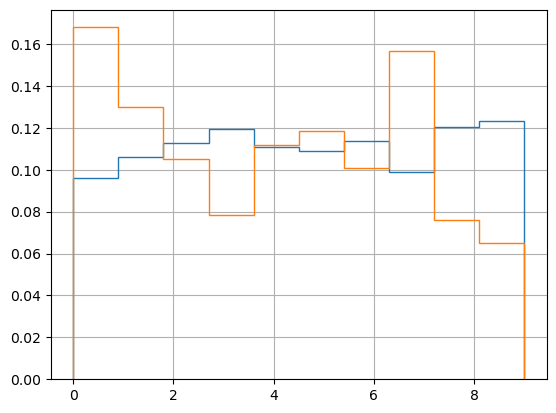

In [121]:
var_to_plot = 'sal_moy'
Data_SISAL_Xnum_cat_Y_notna.groupby('Fraude')[var_to_plot].hist(density=True, histtype='step')

In [122]:
seuil_selection = 0.1
var_Xnum_selected_final_Vcramer = df_cat_cramer.index[np.where(df_cat_cramer['V_Cramer'] > seuil_selection)[0]]
print(len(var_Xnum_selected_final_Vcramer))
print(var_Xnum_selected_final_Vcramer)
# Labels_X_SISAL[var_Xnum_selected_final_Vcramer].T

15
Index(['ancentr', 'pcdi', 'age_ec', 'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec',
       'heu_tec', 'heu_bur', 'sal_fem', 'coti_etat',
       'nombre_mensuel_moyen_sal', 'nbsaison', 'emb_heucdd', 'nbsal'],
      dtype='object')


# Step 8: Building the final base <a id='section_10'></a>

*[Back to Table of contents](#section_0)*

First database

In [123]:
var_Xalpha_final = var_Xalpha_selected.drop(pd.Index(['ccdrpdta7cl','ccdrpdta13cl']))
print(len(var_Xalpha_final))
print(var_Xalpha_final)
Labels_X_SISAL[var_Xalpha_final].T

3
Index(['mensu', 'ccdrpdta15cl', 'classif_algo'], dtype='object')


,0
Variable,
mensu,MENSU
ccdrpdta15cl,Cat. Risque prépondérant AT 15cl
classif_algo,Cat. Risque Algorithmique


In [124]:
var_Xnum_final = var_Xnum_selected_final_Vcramer
print(len(var_Xnum_final))
print(var_Xnum_final)
Labels_X_SISAL[var_Xnum_final].T

15
Index(['ancentr', 'pcdi', 'age_ec', 'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec',
       'heu_tec', 'heu_bur', 'sal_fem', 'coti_etat',
       'nombre_mensuel_moyen_sal', 'nbsaison', 'emb_heucdd', 'nbsal'],
      dtype='object')


,0
Variable,
ancentr,Ancienneté de l'entreprise
pcdi,% salariés en CDI
age_ec,Ecart-type de l'âge du salarié
anc_moy,Ancienneté moyenne du salarié au sein de l'ent...
anc_ec,Ecart_type de l'ancienneté du salarié
sal_moy,Salaire moyen au sein de l'entreprise
sal_ec,Ecart-type du salaire au sein de l'entreprise
heu_tec,Nb heures technique
heu_bur,Nb heures bureau


In [125]:
var_X_Y_final_name = var_Xalpha_final.append(var_Xnum_final).append(pd.Index(['Fraude_num','Montants']))
print(len(var_X_Y_final_name))
var_X_Y_final_name

20


Index(['mensu', 'ccdrpdta15cl', 'classif_algo', 'ancentr', 'pcdi', 'age_ec',
       'anc_moy', 'anc_ec', 'sal_moy', 'sal_ec', 'heu_tec', 'heu_bur',
       'sal_fem', 'coti_etat', 'nombre_mensuel_moyen_sal', 'nbsaison',
       'emb_heucdd', 'nbsal', 'Fraude_num', 'Montants'],
      dtype='object')

In [126]:
var_X_Y_final = Data_SISAL_annual[var_X_Y_final_name]
print(var_X_Y_final.shape)
var_X_Y_final.head()

(162390, 20)


,mensu,ccdrpdta15cl,classif_algo,ancentr,pcdi,age_ec,anc_moy,anc_ec,sal_moy,sal_ec,heu_tec,heu_bur,sal_fem,coti_etat,nombre_mensuel_moyen_sal,nbsaison,emb_heucdd,nbsal,Fraude_num,Montants
0,0,Viticulture,Viticulture,15,0.000000,0.000000,0.00000,0.000000,264.000000,0.000000,24,0,0,0.023306,0.083333,1,24,1,NaN,NaN
1,0,Viticulture,Viticulture,15,0.000000,20.519259,0.20000,0.400000,965.400000,631.881508,447,0,0,0.426141,0.583333,5,260,4,NaN,NaN
2,0,Viticulture,Viticulture,15,0.000000,0.000000,2.00000,0.000000,3502.000000,0.000000,344,0,0,0.345288,-1.500000,1,0,1,NaN,NaN
3,0,Viticulture,Viticulture,15,0.000000,12.256518,0.00000,0.000000,717.000000,331.247138,218,0,0,0.174044,0.250000,3,218,2,NaN,NaN
4,0,Viticulture,Viticulture,14,0.037037,11.699015,0.37037,1.023724,2262.518519,3178.997610,5971,0,6,5.830616,5.500000,26,2885,20,NaN,NaN


In [127]:
# We transform object type variables (categorical) into numeric
label = preprocessing.LabelEncoder() # Transformation of modalities from categorical variables into categories 0, 1, 2 ..
var_X_Y_subset_encoded = pd.DataFrame()  # Empty DataFrame (To fill)
Temp_selection_object = var_X_Y_final[var_X_Y_final.columns].select_dtypes(include=[np.object_]).columns
var_X_Y_subset_to_encode = var_X_Y_final[Temp_selection_object]
var_X_Y_final_encoded = var_X_Y_final.drop(Temp_selection_object, axis = 1)

# Encoding (0,1,2,3 ...)
for i in var_X_Y_subset_to_encode.columns :
    # Name of the categorical variable that is being transformed
    print(i)
    var_X_Y_subset_encoded[i+'_num'] = label.fit_transform(var_X_Y_subset_to_encode[i])

var_X_Y_subset_encoded.index = var_X_Y_final_encoded.index
var_X_Y_final_encoded_annual = pd.concat([var_X_Y_subset_encoded, var_X_Y_final_encoded], axis = 1)

mensu
ccdrpdta15cl
classif_algo


In [128]:
# Exportation de la base de données
var_X_Y_final_encoded_annual.to_excel(path + 'Fake_DataAnnual_SISAL_final_num.xlsx', index = False)

Second database.

Transformation of alpha variables into dichotomised variables.

In [129]:
Data_SISAL_Xccdrpdta15cl_dummies = pd.get_dummies(Data_SISAL_annual['ccdrpdta15cl'])
Data_SISAL_Xccdrpdta15cl_dummies.columns = Data_SISAL_Xccdrpdta15cl_dummies.columns + '_dum'
print(Data_SISAL_Xccdrpdta15cl_dummies.shape)
Data_SISAL_Xccdrpdta15cl_dummies.head()

(162390, 15)


,Activités diverses_dum,Champignonnières_dum,Conchyliculture_dum,Culture et élevage non spécialisés_dum,Cultures spécialisées_dum,Elevage spécialisés gros animaux_dum,Elevage spécialisés petits animaux_dum,"Entrainement, dressage, haras_dum",Entreprises d'artisanat rural_dum,Entreprises de coopération_dum,Entreprises de travaux agricoles_dum,Marais salants_dum,Organismes de service_dum,Travaux forestiers_dum,Viticulture_dum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [130]:
Data_SISAL_Xclassif_algo_dummies = pd.get_dummies(Data_SISAL_annual['classif_algo'])
Data_SISAL_Xclassif_algo_dummies.columns = Data_SISAL_Xclassif_algo_dummies.columns + '_dum'
print(Data_SISAL_Xclassif_algo_dummies.shape)
Data_SISAL_Xclassif_algo_dummies.head()

(162390, 19)


,Act. diverses et Org. service_dum,Conchyliculture_dum,Culture et élevage non spécialisés 0111Z_dum,Culture et élevage non spécialisés autres_dum,Culture et élevage non spécialisés bovins_dum,Cultures spécialisées 0111Z_dum,Cultures spécialisées 0113Z_dum,Cultures spécialisées 0124Z_dum,Cultures spécialisées 0130Z_dum,Cultures spécialisées autres_dum,Elevage spécialisés gros animaux_dum,Elevage spécialisés petits animaux_dum,"Entrainement, dressage, haras_dum",Entreprises de travaux agricoles 0161Z_dum,Entreprises de travaux agricoles 8130Z_dum,Entreprises de travaux agricoles autres_dum,Travaux forestiers activforest_dum,Travaux forestiers autres_dum,Viticulture_dum
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [131]:
Data_SISAL_mensu_dummy = Data_SISAL_annual['mensu'].rename('mensu' + '_dum')
print(Data_SISAL_mensu_dummy.shape)
Data_SISAL_mensu_dummy.head()

(162390,)


0    0
1    0
2    0
3    0
4    0
Name: mensu_dum, dtype: object

Recovery of numerical variables into categorical variables.

In [132]:
var_Xnum_cat_final = var_Xnum_final + '_deciles'
Data_SISAL_Xnum_cat_final = Data_SISAL_Xnum_cat_final[var_Xnum_cat_final]
Data_SISAL_Xnum_cat_final.index = Data_SISAL_mensu_dummy.index
print(Data_SISAL_Xnum_cat_final.shape)

(162390, 15)


In [133]:
Data_SISAL_Y_final = Data_SISAL_annual[['Fraude_num','Montants']]

In [134]:
var_X_Y_final_numcat_dicho = pd.concat([Data_SISAL_mensu_dummy, Data_SISAL_Xccdrpdta15cl_dummies, Data_SISAL_Xclassif_algo_dummies, Data_SISAL_Xnum_cat_final, Data_SISAL_Y_final], axis = 1)
print(var_X_Y_final_numcat_dicho.shape)
var_X_Y_final_numcat_dicho.head()

(162390, 52)


,mensu_dum,Activités diverses_dum,Champignonnières_dum,Conchyliculture_dum,Culture et élevage non spécialisés_dum,Cultures spécialisées_dum,Elevage spécialisés gros animaux_dum,Elevage spécialisés petits animaux_dum,"Entrainement, dressage, haras_dum",Entreprises d'artisanat rural_dum,...,heu_tec_deciles,heu_bur_deciles,sal_fem_deciles,coti_etat_deciles,nombre_mensuel_moyen_sal_deciles,nbsaison_deciles,emb_heucdd_deciles,nbsal_deciles,Fraude_num,Montants
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,1,2,2,1,NaN,NaN
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,0,NaN,NaN
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,NaN,NaN
4,0,0,0,0,0,0,0,0,0,0,...,6,0,4,7,6,5,6,6,NaN,NaN


In [135]:
var_X_Y_final_numcat_dicho.columns

Index(['mensu_dum', 'Activités diverses_dum', 'Champignonnières_dum',
       'Conchyliculture_dum', 'Culture et élevage non spécialisés_dum',
       'Cultures spécialisées_dum', 'Elevage spécialisés gros animaux_dum',
       'Elevage spécialisés petits animaux_dum',
       'Entrainement, dressage, haras_dum',
       'Entreprises d'artisanat rural_dum', 'Entreprises de coopération_dum',
       'Entreprises de travaux agricoles_dum', 'Marais salants_dum',
       'Organismes de service_dum', 'Travaux forestiers_dum',
       'Viticulture_dum', 'Act. diverses et Org. service_dum',
       'Conchyliculture_dum', 'Culture et élevage non spécialisés 0111Z_dum',
       'Culture et élevage non spécialisés autres_dum',
       'Culture et élevage non spécialisés bovins_dum',
       'Cultures spécialisées 0111Z_dum', 'Cultures spécialisées 0113Z_dum',
       'Cultures spécialisées 0124Z_dum', 'Cultures spécialisées 0130Z_dum',
       'Cultures spécialisées autres_dum',
       'Elevage spécialisés gr

In [136]:
var_X_Y_final_numcat_dicho.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [137]:
var_X_Y_final_numcat_dicho = var_X_Y_final_numcat_dicho.iloc[:,~var_X_Y_final_numcat_dicho.columns.duplicated()]

In [138]:
var_X_Y_final_numcat_dicho.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [139]:
# Exporting the database
var_X_Y_final_numcat_dicho.to_excel(path + 'Fake_DataAnnual_SISAL_final_numcat_dicho.xlsx', index = False)

Third database.

Exportation des variables de la base SISAL (hors variables explicatives) que l'on a besoin pour la modélisation.

In [140]:
# Création de la variable Ratio
Data_SISAL['Ratio_masse_tot'] = (Data_SISAL['Montants']/Data_SISAL['masse_tot'])
Data_SISAL['Ratio_coti_tot'] = (Data_SISAL['Montants']/Data_SISAL['coti_tot'])

In [141]:
# Création de la base à exporter
var_SISAL_final_to_export_annual = Data_SISAL[['ccdrpdta15cl','classif_algo','masse_tot','coti_tot','Ratio_masse_tot','Ratio_coti_tot','ctrl_2014','Fraude','Fraude_num','Montants']]
# Exportation de la base de données
var_SISAL_final_to_export_annual.to_excel(path + 'Fake_DataAnnual_SISAL_final_for_analysis.xlsx', index = False)

**Thank you for your attention.**